# Comparison of ML model and OGGM, PYGEM, GLOGEM on point mass balance

In [243]:
# Import libraries
import joblib
import numpy as np
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from tqdm import tqdm
from itertools import product
import dill as pickle
import xarray as xr
import seaborn as sns
from scipy.stats import gaussian_kde

import matplotlib.lines as mlines
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score

from xgboost import XGBRegressor
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from model_classes import CustomXGBRegressor

from plotting_functions import plot_prediction_per_fold
from plotting_functions import plot_prediction
from plotting_functions import plot_gsearch_results

## Classes

#### Custom loss/objective function scikit learn api with metadata

To be used with custom XGBRegressor class

In [27]:
# Custom objective function scikit learn api with metadata, to be used with custom XGBRegressor class
# USE THIS
'''

def custom_mse_metadata(y_true, y_pred, metadata):
    """
    Custom Mean Squared Error (MSE) objective function for evaluating monthly predictions with respect to 
    seasonally or annually aggregated observations.
    
    For use in cases where predictions are done on a monthly time scale and need to be aggregated to be
    compared with the true aggregated seasonal or annual value. Aggregations are performed according to a
    unique ID provided by metadata. The function computes gradients and hessians 
    used in gradient boosting methods, specifically for use with the XGBoost library's custom objective 
    capabilities.
    
    Parameters
    ----------
    y_true : numpy.ndarray
        True (seasonally or annually aggregated) values for each instance. For a unique ID, 
        values are repeated n_months times across the group, e.g. the annual mass balance for a group
        of 12 monthly predictions with the same unique ID is repeated 12 times. Before calculating the 
        loss, the mean over the n unique IDs is taken.
    
    y_pred : numpy.ndarray
        Predicted monthly values. These predictions will be aggregated according to the 
        unique ID before calculating the loss, e.g. 12 monthly predictions with the same unique ID is
        aggregated for evaluation against the true annual value.
    
    metadata : numpy.ndarray
        An ND numpy array containing metadata for each monthly prediction. The first column is mandatory 
        and represents the ID of the aggregated group to which each instance belongs. Each group identified 
        by a unique ID will be aggregated together for the loss calculation. The following columns in the 
        metadata can include additional information for each instance that may be useful for tracking or further 
        processing but are not used in the loss calculation, e.g. number of months to be aggregated or the name 
        of the month.
        
        ID (column 0): An integer that uniquely identifies the group which the instance belongs to.
            
    Returns
    -------
    gradients : numpy.ndarray
        The gradient of the loss with respect to the predictions y_pred. This array has the same shape 
        as y_pred.
    
    hessians : numpy.ndarray
        The second derivative (hessian) of the loss with respect to the predictions y_pred. For MSE loss, 
        the hessian is constant and thus this array is filled with ones, having the same shape as y_pred.
    """
            
    # Initialize gradients and hessians
    gradients = np.zeros_like(y_pred)
    hessians = np.ones_like(y_pred)

    # Get the aggregated predictions and the mean score based on the true labels, and predicted labels
    # based on the metadata.
    #y_pred_agg, y_true_mean, grouped_ids, df_metadata = CustomXGBoostRegressor._create_metadata_scores(metadata, y_true, y_pred)
    df_metadata = pd.DataFrame(metadata, columns=['ID', 'N_MONTHS', 'MONTH'])

    # Aggregate y_pred and y_true for each group
    grouped_ids = df_metadata.assign(y_true=y_true, y_pred=y_pred).groupby('ID')
    y_pred_agg = grouped_ids['y_pred'].sum().values
    y_true_mean = grouped_ids['y_true'].mean().values
    
    # Compute gradients
    gradients_agg = y_pred_agg - y_true_mean

    # Create a mapping from ID to gradient
    gradient_map = dict(zip(grouped_ids.groups.keys(), gradients_agg))

    # Assign gradients to corresponding indices
    df_metadata['gradient'] = df_metadata['ID'].map(gradient_map)
    gradients[df_metadata.index] = df_metadata['gradient'].values

    return gradients, hessians

#### Custom estimator class based on XGBRegressor

Inherits from xgboost.XGBRegressor 

Note/to-do: Modify def __init__(self,..) to retrieve kwarg for number of columns of metadata (n_metadata) with default n_metadata=None, to allow for flexibility in the number of metadata columns.

In [28]:
# REFACTORED VERSION
'''
class CustomXGBRegressor(XGBRegressor):
    """
    CustomXGBRegressor is an extension of the XGBoost regressor that incorporates additional metadata into the learning process. The estimator
    is tailored to handle training datasets where the last three columns are metadata rather than features.
    
    The metadata is utilized in a custom mean squared error function. This function calculates gradients and hessians incorporating metadata, 
    allowing the model to learn from both standard feature data and additional information provided as metadata.
    
    The custom objective closure captures metadata along with the target values and predicted values to compute the gradients and hessians needed
    for the XGBoost training process.

    The class contains a custom score function (custom mse) that is used in GridSearchCV to evaluate validation performance for each fold.
    This is the default scorer for the class.
    
    Parameters inherited from XGBRegressor are customizable and additional parameters can be passed via kwargs, which will be handled by the
    XGBRegressor's __init__ method.
    
    Examples
    --------
    >>> model = CustomXGBRegressor(n_estimators=500, learning_rate=0.05)
    >>> model.fit(X_train, y_train)  # X_train includes metadata as the last 3 columns
    >>> predictions = model.predict(X_test)  # X_test includes metadata as the last 3 columns
    
    Note: CustomXGBRegressor requires a custom MSE function, `custom_mse_metadata`, which computes the gradient and hessian using additional metadata.
    """
    
    def __init__(self, metadata_shape=3, **kwargs):
        self.metadata_shape = metadata_shape
        super().__init__(**kwargs)

    def fit(self, X, y, **fit_params):
        # Split features from metadata
        metadata, features = X[:, -self.metadata_shape:], X[:, :-self.metadata_shape]

        # Define closure that captures metadata for use in custom objective
        def custom_objective(y_true, y_pred):
            return custom_mse_metadata(y_true, y_pred, metadata)

        # Set custom objective
        self.set_params(objective=custom_objective)

        # Call fit method from parent class (XGBRegressor)
        super().fit(features, y, **fit_params)

        return self

    def predict(self, X):
        # Check if the model is fitted
        check_is_fitted(self)
        
        features = X[:, :-self.metadata_shape]
        
        return super().predict(features)

    def score(self, X, y, sample_weight=None):

        y_pred = self.predict(X)

        metadata, features = X[:, -self.metadata_shape:], X[:, :-self.metadata_shape]
        
        # Get the aggregated predictions and the mean score based on the true labels, and predicted labels
        # based on the metadata.
        df_metadata = pd.DataFrame(metadata, columns=['ID', 'N_MONTHS', 'MONTH'])

        # Aggregate y_pred and y_true for each group
        grouped_ids = df_metadata.assign(y_true=y, y_pred=y_pred).groupby('ID')
        y_pred_agg = grouped_ids['y_pred'].sum().values
        y_true_mean = grouped_ids['y_true'].mean().values

        # Compute mse 
        mse = ((y_pred_agg - y_true_mean) ** 2).mean()

        return -mse # Return negative because GridSearchCV maximizes score          


## Helper functions

In [29]:
# Get modelled mass balance from xarray Dataset based on 
# dataframe of point mass balances

def get_modelled_mb(df, ds, type):
    """
    df : pd.DataFrame of point mb (mass balance)
    ds : xr.DataSet of modelled mass balance
    type : str, variable in ds; 'mb_annual', 'mb_summer', or 'mb_winter'
    """
    
    mb_modelled = []

    # Loop through each row of df to extract modelled mb for the given ID, year, and nearest elevation
    for row in df.itertuples(index=False):

        # Use the attributes of namedtuple
        current_year = str(row.year) + '-10-01'
        current_altitude = row.altitude
        current_id = str(row.ID)
        current_year_dt = np.datetime64(current_year)

        # Check if the current_year_dt is in the 'time' coordinate of the dataset
        if current_year_dt in ds['time'].values:

            # Find nearest elevation to point
            nearest_elevation_idx = abs(ds['elevation'] - current_altitude).argmin()
            nearest_elevation = ds['elevation'][nearest_elevation_idx]

            # Check if current_id exists in the 'ID' coordinate of the dataset
            if current_id in ds['ID'].values:

                mb_val = ds[type].sel(
                    ID=current_id, time=current_year_dt, elevation=nearest_elevation).values

                mb_val = mb_val.item()
            else:
                mb_val = np.nan
        else:
            # If modelled mb is not available for the current year, use nan
            mb_val = np.nan

        mb_modelled.append(mb_val)

    return mb_modelled


In [30]:
# Get true values (means) and predicted values (aggregates)

def get_ytrue_y_pred_agg(y_true, y_pred, X):
    # Extract the metadata
    metadata = X[:, -3:]  # Assuming last three columns are the metadata
    unique_ids = np.unique(metadata[:, 0]) # Assuming ID is the first column
    y_pred_agg_all = []
    y_true_mean_all = []
    
    # Loop over each unique ID to calculate MSE
    for uid in unique_ids:
        # Indexes for the current ID
        indexes = metadata[:, 0] == uid
        # Aggregate y_pred for the current ID
        y_pred_agg = np.sum(y_pred[indexes])
        y_pred_agg_all.append(y_pred_agg)
        # True value is the mean of true values for the group
        y_true_mean = np.mean(y_true[indexes])
        y_true_mean_all.append(y_true_mean)

    y_pred_agg_all_arr = np.array(y_pred_agg_all)
    y_true_mean_all_arr = np.array(y_true_mean_all)
    
    return y_true_mean_all_arr, y_pred_agg_all_arr

In [31]:
def get_ytrue_y_pred_agg_season(y_true, y_pred, X, months=12):

    # Get values for the given season
    mask = X[:, -2] == months  
    X = X[mask] 
    
    # Extract the metadata
    metadata = X[:, -3:]  # Assuming last three columns are the metadata
    unique_ids = np.unique(metadata[:, 0]) # Assuming ID is the first column
    y_pred_agg_all = []
    y_true_mean_all = []
    
    # Loop over each unique ID to calculate MSE
    for uid in unique_ids:
        # Indexes for the current ID
        indexes = metadata[:, 0] == uid
        # Aggregate y_pred for the current ID
        y_pred_agg = np.sum(y_pred[indexes])
        y_pred_agg_all.append(y_pred_agg)
        # True value is the mean of true values for the group
        y_true_mean = np.mean(y_true[indexes])
        y_true_mean_all.append(y_true_mean)

    y_pred_agg_all_arr = np.array(y_pred_agg_all)
    y_true_mean_all_arr = np.array(y_true_mean_all)
    
    return y_true_mean_all_arr, y_pred_agg_all_arr

In [32]:
def get_prediction_per_season_test(X_test, y_test, best_model, months=12):

    y_pred = best_model.predict(X_test)

    indices = np.argwhere((X_test[:,-2] == months))[:,0]
    y_test_crop = y_test[indices]
    y_pred_crop = y_pred[indices]

    return y_test_crop, y_pred_crop

## Plotting functions

In [33]:
# Plot modelled and observed point mass balances

def plot_point_modelled(df, model, start_yr, end_yr):

    """
    df : pd.Dataframe of point mb
    type : str, variable in ds; 'netto', 'summer' or 'winter'
    model : str, model name; 'glogem', 'oggm', 'pygem'
    """

    df_clean_dropna = df.dropna(subset=['mb_'+model])

    df_clean = df_clean_dropna[(df_clean_dropna['year'] >= start_yr) & (df_clean_dropna['year'] <= end_yr)]

    y_data = df_clean['mb_'+model]
    x_data = df_clean['balance']
    
    xy = np.vstack([x_data, y_data])
    z = gaussian_kde(xy)(xy)

    df_with_density = pd.DataFrame({
        'x': x_data,
        'y': y_data,
        'z': z
        })

    df_with_density.sort_values('z', inplace=True)

    fig, ax = plt.subplots()
    scatter = ax.scatter(df_with_density['x'], df_with_density['y'], c=df_with_density['z'], s=50, cmap='viridis')

    max_val = max(x_data.max(), y_data.max())+0.5
    min_val = min(x_data.min(), y_data.min())-0.5
    
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='1:1 Line')
    ax.set_aspect('equal', adjustable='box')
    
    ax.set_xlabel('mb stake (m w.e.)')
    ax.set_ylabel('mb modelled elev band (m w.e.)')
    plt.title('Stake vs. ' + model)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_data, x_data))
    mae = mean_absolute_error(y_data, x_data) 
    r2 = r2_score(y_data, x_data) 
    count = len(x_data)  # Count the number of data points
    
    stats_text = f'Count: {count}\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}\n$R^2$: {r2:.2f}'
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.5))
    
    #plt.legend()
    plt.colorbar(ax.collections[0], ax=ax, label='Density')
    plt.tight_layout()
    plt.grid(alpha=0.5)
    plt.show()

    #max_val = max(df_clean['mb_'+model].max(), df_clean['balance_'+type].max())
    #min_val = min(df_clean['mb_'+model].min(), df_clean['balance_'+type].min())

    #ax.set_xlim(min_val * 1.05, max_val +0.5)
    #ax.set_ylim(min_val * 1.05, max_val +0.5)

    #ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='1:1 Line')
    #ax.set_aspect('equal', adjustable='box')

    #ax.set_xlabel('mb_modelled_elev_band')
    #ax.set_ylabel('mb_stake')
    #ax.legend(title='ID', bbox_to_anchor=(1.05, 1), loc='upper left')
    #plt.title('Stake ' + type + ' vs. '+ model)

    # Calculate metrics
    #rmse = np.sqrt(mean_squared_error(df_clean['balance_'+ type], df_clean['mb_'+ model]))
    #mae = mean_absolute_error(df_clean['balance_' + type], df_clean['mb_'+ model])
    #r2 = r2_score(df_clean['balance_' + type], df_clean['mb_'+ model])
    #count = len(df_clean)  # Count the number of data points

    #stats_text = f'Count: {count}\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}\n$R^2$: {r2:.2f}'
    #ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=9,
    #    verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.5))

    #plt.tight_layout()
    #plt.show()

    #print(f"Root Mean Squared Error (RMSE): {rmse}")
    #print(f"Mean Absolute Error (MAE): {mae}")
    #print(f"R-squared (R^2): {r2}")

In [34]:
def plot_prediction_per_season(y_test_all, y_pred_all, season='Annual'):

    from scipy.stats import gaussian_kde
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error
    
    figsize=(5,5)
    fontsize=16
    s= 20
    n_toplot=10**10
    
    idxs = np.arange(len(y_test_all))
    np.random.shuffle(idxs)

    y_max = 8#7 #max(max(y1), max(y2))[0] + 1
    y_min = -15#1 #min(min(y1), min(y2))[0] - 1
    
    y_expected = y_test_all.reshape(-1)[idxs[:n_toplot]]
    y_predicted = y_pred_all.reshape(-1)[idxs[:n_toplot]]

    xy = np.vstack([y_expected, y_predicted])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    y_plt, ann_plt, z = y_expected[idx], y_predicted[idx], z[idx]
    
    fig = plt.figure(figsize=figsize, dpi=100)
    plt.title(season + " mass balance", fontsize=20)
    plt.ylabel('Modeled mass balance (m w.e)', fontsize=fontsize)
    plt.xlabel('Observed mass balance (m w.e)', fontsize=fontsize)
    sc = plt.scatter(y_plt, ann_plt, c=z, s=s)
    plt.clim(0,0.4)
    plt.tick_params(labelsize=14)
    #plt.colorbar(sc) 
    lineStart = y_min
    lineEnd = y_max
    plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-')
    plt.axvline(0.0, ls='-.', c='k')
    plt.axhline(0.0, ls='-.', c='k')
    plt.xlim(lineStart, lineEnd)
    plt.ylim(lineStart, lineEnd)
    plt.gca().set_box_aspect(1)
    
    textstr = '\n'.join((
    r'$RMSE=%.2f$' % (root_mean_squared_error(y_expected, y_predicted), ),
    r'$MSE=%.2f$' % (mean_squared_error(y_expected, y_predicted, ), ),
    r'$MAE=%.2f$' % (mean_absolute_error(y_expected, y_predicted), ),
    r'$R^2=%.2f$' % (r2_score(y_expected, y_predicted), )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # place a text box in upper left in axes coords
    plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    plt.tight_layout()
    plt.show()

## Get test dataset of monthly values 

14 glaciers: [54, 703, 941, 1135, 1280, 2085, 2320, 2478, 2768, 2769, 3133, 3137, 3138, 3141]

- 54: 189 points
- 703: 30 points
- 941: 70 points
- 1135: 
- 1280: 71 points
- 2085: 
- 2320: 83 points
- 2478: 89 points
- 2768:
- 2769: 121 points
- 3133: 38 points
- 3137: 65 points
- 3138: 6 points
- 3141: 72 points

In [35]:
# Specify filepaths and filenames.          
loc = 'local'

if loc == 'cryocloud':
    filepath = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath = 'Data/'

filename = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate_test_svf.csv'

# Load data.
df_test_final = pd.read_csv(filepath + filename, index_col=0)

In [36]:
df_test_final

id  BREID           RGIID  year  altitude_diff  altitude  \
0         0     54  RGI60-08.01258  2013    -129.772081     471.0   
1         0     54  RGI60-08.01258  2013    -129.772081     471.0   
2         0     54  RGI60-08.01258  2013    -129.772081     471.0   
3         0     54  RGI60-08.01258  2013    -129.772081     471.0   
4         0     54  RGI60-08.01258  2013    -129.772081     471.0   
...     ...    ...             ...   ...            ...       ...   
24915  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   
24916  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   
24917  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   
24918  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   
24919  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   

       altitude_climate  balance    aspect     slope  skyview_factor  \
0            341.227919    -6.24  0.629597  0.278773        0.778997   
1            341.227919    -6.24  0.629597  0.278773        0.778997   
2            341.227919    -6.24  0.629597  0.278773        0.778997   
3            341.227919    -6.24  0.629597  0.278773        0.778997   
4            341.227919    -6.24  0.629597  0.278773        0.778997   
...                 ...      ...       ...       ...             ...   
24915        917.419759    -3.29  2.906044  0.131717        0.932281   
24916        917.419759    -3.29  2.906044  0.131717        0.932281   
24917        917.419759    -3.29  2.906044  0.131717        0.932281   
24918        917.419759    -3.29  2.906044  0.131717        0.932281   
24919        917.419759    -3.29  2.906044  0.131717        0.932281   

       n_months month         t2m          sshf       slhf        ssrd  \
0             5   may  277.677979  4.286715e+05  -237874.5  20979516.0   
1             5   jun  283.339630 -2.133166e+06 -4024573.5  17728592.0   
2             5   jul  283.829285 -2.731458e+06 -5184939.5  15538729.0   
3             5   aug  283.778412 -1.295387e+06 -3545874.5  10510849.0   
4             5   sep  280.982513  9.352438e+03 -1756179.5   6908671.0   
...         ...   ...         ...           ...        ...         ...   
24915        12   may  277.690887 -5.189375e+02   -71670.0  17926120.0   
24916        12   jun  280.319031  1.046328e+05  -101796.5  13385372.0   
24917        12   jul  282.416504 -2.174798e+06 -4535185.5  15446657.0   
24918        12   aug  281.939026 -1.997971e+06 -3884410.5  11212546.0   
24919        12   sep  280.775269 -9.919489e+05 -2517502.0   7614423.5   

            fal         str        tp  
0      0.580414 -3367191.50  0.001159  
1      0.198752 -3994740.00  0.003054  
2      0.131911 -4661453.00  0.003977  
3      0.130799 -4018348.50  0.004691  
4      0.130148 -4441106.50  0.001449  
...         ...         ...       ...  
24915  0.530146 -2093793.25  0.003567  
24916  0.480811   162197.00  0.008162  
24917  0.183955 -3726261.25  0.007537  
24918  0.135438 -3417520.00  0.007390  
24919  0.133470 -3192232.00  0.006440  

[24920 rows x 20 columns]

In [37]:
# Drop strange 9.99 winter mb value for 2768

#idx_remove = df_test_final['balance'].idxmax()
#df_test_final = df_test_final.drop(idx_remove)
#df_test_final.reset_index(drop=True, inplace=True)

df_test_final = df_test_final[df_test_final['balance'] != 9.99].reset_index(drop=True)


In [38]:
df_test_final

id  BREID           RGIID  year  altitude_diff  altitude  \
0         0     54  RGI60-08.01258  2013    -129.772081     471.0   
1         0     54  RGI60-08.01258  2013    -129.772081     471.0   
2         0     54  RGI60-08.01258  2013    -129.772081     471.0   
3         0     54  RGI60-08.01258  2013    -129.772081     471.0   
4         0     54  RGI60-08.01258  2013    -129.772081     471.0   
...     ...    ...             ...   ...            ...       ...   
24908  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   
24909  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   
24910  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   
24911  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   
24912  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   

       altitude_climate  balance    aspect     slope  skyview_factor  \
0            341.227919    -6.24  0.629597  0.278773        0.778997   
1            341.227919    -6.24  0.629597  0.278773        0.778997   
2            341.227919    -6.24  0.629597  0.278773        0.778997   
3            341.227919    -6.24  0.629597  0.278773        0.778997   
4            341.227919    -6.24  0.629597  0.278773        0.778997   
...                 ...      ...       ...       ...             ...   
24908        917.419759    -3.29  2.906044  0.131717        0.932281   
24909        917.419759    -3.29  2.906044  0.131717        0.932281   
24910        917.419759    -3.29  2.906044  0.131717        0.932281   
24911        917.419759    -3.29  2.906044  0.131717        0.932281   
24912        917.419759    -3.29  2.906044  0.131717        0.932281   

       n_months month         t2m          sshf       slhf        ssrd  \
0             5   may  277.677979  4.286715e+05  -237874.5  20979516.0   
1             5   jun  283.339630 -2.133166e+06 -4024573.5  17728592.0   
2             5   jul  283.829285 -2.731458e+06 -5184939.5  15538729.0   
3             5   aug  283.778412 -1.295387e+06 -3545874.5  10510849.0   
4             5   sep  280.982513  9.352438e+03 -1756179.5   6908671.0   
...         ...   ...         ...           ...        ...         ...   
24908        12   may  277.690887 -5.189375e+02   -71670.0  17926120.0   
24909        12   jun  280.319031  1.046328e+05  -101796.5  13385372.0   
24910        12   jul  282.416504 -2.174798e+06 -4535185.5  15446657.0   
24911        12   aug  281.939026 -1.997971e+06 -3884410.5  11212546.0   
24912        12   sep  280.775269 -9.919489e+05 -2517502.0   7614423.5   

            fal         str        tp  
0      0.580414 -3367191.50  0.001159  
1      0.198752 -3994740.00  0.003054  
2      0.131911 -4661453.00  0.003977  
3      0.130799 -4018348.50  0.004691  
4      0.130148 -4441106.50  0.001449  
...         ...         ...       ...  
24908  0.530146 -2093793.25  0.003567  
24909  0.480811   162197.00  0.008162  
24910  0.183955 -3726261.25  0.007537  
24911  0.135438 -3417520.00  0.007390  
24912  0.133470 -3192232.00  0.006440  

[24913 rows x 20 columns]

In [39]:
# Add column for short form RGIID for retreival of model results
df_test_final['ID'] = df_test_final['RGIID'].str[-4:] # Short form of RGIID

In [40]:
df_test_final.ID = df_test_final.ID.astype(int)
df_test_final

id  BREID           RGIID  year  altitude_diff  altitude  \
0         0     54  RGI60-08.01258  2013    -129.772081     471.0   
1         0     54  RGI60-08.01258  2013    -129.772081     471.0   
2         0     54  RGI60-08.01258  2013    -129.772081     471.0   
3         0     54  RGI60-08.01258  2013    -129.772081     471.0   
4         0     54  RGI60-08.01258  2013    -129.772081     471.0   
...     ...    ...             ...   ...            ...       ...   
24908  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   
24909  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   
24910  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   
24911  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   
24912  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   

       altitude_climate  balance    aspect     slope  ...  n_months  month  \
0            341.227919    -6.24  0.629597  0.278773  ...         5    may   
1            341.227919    -6.24  0.629597  0.278773  ...         5    jun   
2            341.227919    -6.24  0.629597  0.278773  ...         5    jul   
3            341.227919    -6.24  0.629597  0.278773  ...         5    aug   
4            341.227919    -6.24  0.629597  0.278773  ...         5    sep   
...                 ...      ...       ...       ...  ...       ...    ...   
24908        917.419759    -3.29  2.906044  0.131717  ...        12    may   
24909        917.419759    -3.29  2.906044  0.131717  ...        12    jun   
24910        917.419759    -3.29  2.906044  0.131717  ...        12    jul   
24911        917.419759    -3.29  2.906044  0.131717  ...        12    aug   
24912        917.419759    -3.29  2.906044  0.131717  ...        12    sep   

              t2m          sshf       slhf        ssrd       fal         str  \
0      277.677979  4.286715e+05  -237874.5  20979516.0  0.580414 -3367191.50   
1      283.339630 -2.133166e+06 -4024573.5  17728592.0  0.198752 -3994740.00   
2      283.829285 -2.731458e+06 -5184939.5  15538729.0  0.131911 -4661453.00   
3      283.778412 -1.295387e+06 -3545874.5  10510849.0  0.130799 -4018348.50   
4      280.982513  9.352438e+03 -1756179.5   6908671.0  0.130148 -4441106.50   
...           ...           ...        ...         ...       ...         ...   
24908  277.690887 -5.189375e+02   -71670.0  17926120.0  0.530146 -2093793.25   
24909  280.319031  1.046328e+05  -101796.5  13385372.0  0.480811   162197.00   
24910  282.416504 -2.174798e+06 -4535185.5  15446657.0  0.183955 -3726261.25   
24911  281.939026 -1.997971e+06 -3884410.5  11212546.0  0.135438 -3417520.00   
24912  280.775269 -9.919489e+05 -2517502.0   7614423.5  0.133470 -3192232.00   

             tp    ID  
0      0.001159  1258  
1      0.003054  1258  
2      0.003977  1258  
3      0.004691  1258  
4      0.001449  1258  
...         ...   ...  
24908  0.003567  2969  
24909  0.008162  2969  
24910  0.007537  2969  
24911  0.007390  2969  
24912  0.006440  2969  

[24913 rows x 21 columns]

### Get targets and features for ML model

In [41]:
# Select features for test
df_test_X_reduce = df_test_final.drop(['balance','year','BREID','RGIID', 'ID','altitude','altitude_climate'], axis=1)

# Move id and n_months to the end of the dataframe (these are to be used as metadata)
df_test_X = df_test_X_reduce[[c for c in df_test_X_reduce if c not in ['id','n_months','month']] + ['id','n_months','month']]

# Select labels for test
df_test_y = df_test_final[['balance']]

# Get arrays of features+metadata and targets
X_test, y_test = df_test_X.values, df_test_y.values

In [42]:
df_test_X_reduce

id  altitude_diff    aspect     slope  skyview_factor  n_months  \
0         0    -129.772081  0.629597  0.278773        0.778997         5   
1         0    -129.772081  0.629597  0.278773        0.778997         5   
2         0    -129.772081  0.629597  0.278773        0.778997         5   
3         0    -129.772081  0.629597  0.278773        0.778997         5   
4         0    -129.772081  0.629597  0.278773        0.778997         5   
...     ...            ...       ...       ...             ...       ...   
24908  3092    -160.580241  2.906044  0.131717        0.932281        12   
24909  3092    -160.580241  2.906044  0.131717        0.932281        12   
24910  3092    -160.580241  2.906044  0.131717        0.932281        12   
24911  3092    -160.580241  2.906044  0.131717        0.932281        12   
24912  3092    -160.580241  2.906044  0.131717        0.932281        12   

      month         t2m          sshf       slhf        ssrd       fal  \
0       may  277.677979  4.286715e+05  -237874.5  20979516.0  0.580414   
1       jun  283.339630 -2.133166e+06 -4024573.5  17728592.0  0.198752   
2       jul  283.829285 -2.731458e+06 -5184939.5  15538729.0  0.131911   
3       aug  283.778412 -1.295387e+06 -3545874.5  10510849.0  0.130799   
4       sep  280.982513  9.352438e+03 -1756179.5   6908671.0  0.130148   
...     ...         ...           ...        ...         ...       ...   
24908   may  277.690887 -5.189375e+02   -71670.0  17926120.0  0.530146   
24909   jun  280.319031  1.046328e+05  -101796.5  13385372.0  0.480811   
24910   jul  282.416504 -2.174798e+06 -4535185.5  15446657.0  0.183955   
24911   aug  281.939026 -1.997971e+06 -3884410.5  11212546.0  0.135438   
24912   sep  280.775269 -9.919489e+05 -2517502.0   7614423.5  0.133470   

              str        tp  
0     -3367191.50  0.001159  
1     -3994740.00  0.003054  
2     -4661453.00  0.003977  
3     -4018348.50  0.004691  
4     -4441106.50  0.001449  
...           ...       ...  
24908 -2093793.25  0.003567  
24909   162197.00  0.008162  
24910 -3726261.25  0.007537  
24911 -3417520.00  0.007390  
24912 -3192232.00  0.006440  

[24913 rows x 14 columns]

### Get dataframes of annual, summer and winter mass balances for comparison

In [43]:
df_test_final

id  BREID           RGIID  year  altitude_diff  altitude  \
0         0     54  RGI60-08.01258  2013    -129.772081     471.0   
1         0     54  RGI60-08.01258  2013    -129.772081     471.0   
2         0     54  RGI60-08.01258  2013    -129.772081     471.0   
3         0     54  RGI60-08.01258  2013    -129.772081     471.0   
4         0     54  RGI60-08.01258  2013    -129.772081     471.0   
...     ...    ...             ...   ...            ...       ...   
24908  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   
24909  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   
24910  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   
24911  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   
24912  3092   3141  RGI60-08.02969  2017    -160.580241    1078.0   

       altitude_climate  balance    aspect     slope  ...  n_months  month  \
0            341.227919    -6.24  0.629597  0.278773  ...         5    may   
1            341.227919    -6.24  0.629597  0.278773  ...         5    jun   
2            341.227919    -6.24  0.629597  0.278773  ...         5    jul   
3            341.227919    -6.24  0.629597  0.278773  ...         5    aug   
4            341.227919    -6.24  0.629597  0.278773  ...         5    sep   
...                 ...      ...       ...       ...  ...       ...    ...   
24908        917.419759    -3.29  2.906044  0.131717  ...        12    may   
24909        917.419759    -3.29  2.906044  0.131717  ...        12    jun   
24910        917.419759    -3.29  2.906044  0.131717  ...        12    jul   
24911        917.419759    -3.29  2.906044  0.131717  ...        12    aug   
24912        917.419759    -3.29  2.906044  0.131717  ...        12    sep   

              t2m          sshf       slhf        ssrd       fal         str  \
0      277.677979  4.286715e+05  -237874.5  20979516.0  0.580414 -3367191.50   
1      283.339630 -2.133166e+06 -4024573.5  17728592.0  0.198752 -3994740.00   
2      283.829285 -2.731458e+06 -5184939.5  15538729.0  0.131911 -4661453.00   
3      283.778412 -1.295387e+06 -3545874.5  10510849.0  0.130799 -4018348.50   
4      280.982513  9.352438e+03 -1756179.5   6908671.0  0.130148 -4441106.50   
...           ...           ...        ...         ...       ...         ...   
24908  277.690887 -5.189375e+02   -71670.0  17926120.0  0.530146 -2093793.25   
24909  280.319031  1.046328e+05  -101796.5  13385372.0  0.480811   162197.00   
24910  282.416504 -2.174798e+06 -4535185.5  15446657.0  0.183955 -3726261.25   
24911  281.939026 -1.997971e+06 -3884410.5  11212546.0  0.135438 -3417520.00   
24912  280.775269 -9.919489e+05 -2517502.0   7614423.5  0.133470 -3192232.00   

             tp    ID  
0      0.001159  1258  
1      0.003054  1258  
2      0.003977  1258  
3      0.004691  1258  
4      0.001449  1258  
...         ...   ...  
24908  0.003567  2969  
24909  0.008162  2969  
24910  0.007537  2969  
24911  0.007390  2969  
24912  0.006440  2969  

[24913 rows x 21 columns]

In [44]:
df_test_annual = df_test_final[df_test_final['n_months']==12]
df_test_annual = df_test_annual.groupby(by=['id']).mean() 
df_test_annual

C:\Users\kasj\AppData\Local\Temp\ipykernel_11496\4077999050.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_test_annual = df_test_annual.groupby(by=['id']).mean()


BREID    year  altitude_diff  altitude  altitude_climate  balance  \
id                                                                         
2028    54.0  2013.0    -129.772081     471.0        341.227919    -4.92   
2029    54.0  2014.0     -97.772081     439.0        341.227919    -2.67   
2030    54.0  2015.0    -102.772081     444.0        341.227919    -3.41   
2031    54.0  2016.0    -102.772081     444.0        341.227919    -3.59   
2032    54.0  2017.0    -126.772081     468.0        341.227919    -2.46   
...      ...     ...            ...       ...               ...      ...   
3088  3141.0  2012.0    -160.580241    1078.0        917.419759    -2.07   
3089  3141.0  2013.0    -160.580241    1078.0        917.419759    -3.15   
3090  3141.0  2015.0    -161.580241    1079.0        917.419759    -2.61   
3091  3141.0  2016.0    -160.580241    1078.0        917.419759    -2.66   
3092  3141.0  2017.0    -160.580241    1078.0        917.419759    -3.29   

        aspect     slope  skyview_factor  n_months         t2m           sshf  \
id                                                                              
2028  0.629597  0.278773        0.778997      12.0  273.045766  -10104.210938   
2029  0.585924  0.296590        0.798494      12.0  272.938726  225771.765625   
2030  0.663261  0.302508        0.803510      12.0  272.849403  133388.494792   
2031  0.663261  0.302508        0.803510      12.0  273.300074  -14896.781250   
2032  0.836757  0.309196        0.817480      12.0  272.918989  279420.552083   
...        ...       ...             ...       ...         ...            ...   
3088  2.906044  0.131717        0.932281      12.0  274.500407 -340938.494792   
3089  2.906044  0.131717        0.932281      12.0  272.949669 -419158.447917   
3090  2.906044  0.131717        0.932281      12.0  274.638379 -144798.453125   
3091  2.906044  0.131717        0.932281      12.0  275.167430 -404816.317708   
3092  2.906044  0.131717        0.932281      12.0  274.879850 -432534.911458   

              slhf          ssrd       fal           str        tp      ID  
id                                                                          
2028 -1.192698e+06  8.000492e+06  0.534814 -2.960371e+06  0.003176  1258.0  
2029 -8.952235e+05  7.755540e+06  0.585304 -2.756938e+06  0.003372  1258.0  
2030 -9.804107e+05  7.343682e+06  0.556681 -2.772570e+06  0.003141  1258.0  
2031 -1.064662e+06  7.145984e+06  0.540813 -2.628417e+06  0.003110  1258.0  
2032 -7.474015e+05  7.817598e+06  0.538918 -2.767568e+06  0.003548  1258.0  
...            ...           ...       ...           ...       ...     ...  
3088 -8.186743e+05  8.780470e+06  0.547067 -2.065823e+06  0.008703  2969.0  
3089 -1.114851e+06  9.078827e+06  0.541262 -2.491021e+06  0.006297  2969.0  
3090 -6.082808e+05  8.741161e+06  0.560521 -1.893852e+06  0.009249  2969.0  
3091 -1.068619e+06  8.679002e+06  0.501434 -2.248240e+06  0.008690  2969.0  
3092 -1.075172e+06  8.313585e+06  0.515644 -2.167410e+06  0.007674  2969.0  

[1065 rows x 18 columns]

In [45]:
df_test_winter = df_test_final[df_test_final['n_months']==7]
df_test_winter = df_test_winter.groupby(by=['id']).mean() 
df_test_winter

C:\Users\kasj\AppData\Local\Temp\ipykernel_11496\3206729110.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_test_winter = df_test_winter.groupby(by=['id']).mean()


BREID    year  altitude_diff  altitude  altitude_climate  balance  \
id                                                                         
1028    54.0  2013.0    -129.772081     471.0        341.227919     1.32   
1029    54.0  2014.0     -97.772081     439.0        341.227919     1.68   
1030    54.0  2015.0    -102.772081     444.0        341.227919     0.76   
1031    54.0  2016.0    -102.772081     444.0        341.227919     0.78   
1032    54.0  2017.0    -126.772081     468.0        341.227919     1.59   
...      ...     ...            ...       ...               ...      ...   
2023  3141.0  2012.0    -160.580241    1078.0        917.419759     1.50   
2024  3141.0  2013.0    -160.580241    1078.0        917.419759     1.14   
2025  3141.0  2015.0    -161.580241    1079.0        917.419759     1.19   
2026  3141.0  2016.0    -160.580241    1078.0        917.419759     1.72   
2027  3141.0  2017.0    -160.580241    1078.0        917.419759     1.15   

        aspect     slope  skyview_factor  n_months         t2m           sshf  \
id                                                                              
1028  0.629597  0.278773        0.778997       7.0  266.705911  800105.232143   
1029  0.585924  0.296590        0.798494       7.0  267.740727  996367.901786   
1030  0.663261  0.302508        0.803510       7.0  267.579795  946459.196429   
1031  0.663261  0.302508        0.803510       7.0  267.811977  868039.937500   
1032  0.836757  0.309196        0.817480       7.0  268.226903  856574.433036   
...        ...       ...             ...       ...         ...            ...   
2023  2.906044  0.131717        0.932281       7.0  270.836827   23270.491071   
2024  2.906044  0.131717        0.932281       7.0  267.233730  125356.500000   
2025  2.906044  0.131717        0.932281       7.0  271.190260   -7447.285714   
2026  2.906044  0.131717        0.932281       7.0  270.403787   18733.339286   
2027  2.906044  0.131717        0.932281       7.0  270.773926  -18544.928571   

               slhf          ssrd       fal           str        tp      ID  
id                                                                           
1028   62438.500000  3.477078e+06  0.749392 -2.148801e+06  0.003397  1258.0  
1029   65465.714286  3.052352e+06  0.758143 -2.145037e+06  0.003847  1258.0  
1030   21334.214286  3.186665e+06  0.750785 -2.258321e+06  0.002979  1258.0  
1031  102229.642857  3.540237e+06  0.771447 -2.084224e+06  0.003243  1258.0  
1032   64772.571429  3.494867e+06  0.679859 -2.391737e+06  0.003806  1258.0  
...             ...           ...       ...           ...       ...     ...  
2023 -171713.642857  4.804682e+06  0.683440 -1.769234e+06  0.010046  2969.0  
2024 -123023.142857  5.492646e+06  0.711911 -2.165743e+06  0.006262  2969.0  
2025 -271647.642857  4.664342e+06  0.653273 -1.837262e+06  0.011195  2969.0  
2026 -251040.928571  5.058185e+06  0.655849 -1.987646e+06  0.009280  2969.0  
2027 -255928.142857  4.882558e+06  0.674844 -1.963044e+06  0.008427  2969.0  

[999 rows x 18 columns]

In [46]:
df_test_summer = df_test_final[df_test_final['n_months']==5]
df_test_summer = df_test_summer.groupby(by=['id']).mean() 
df_test_summer

C:\Users\kasj\AppData\Local\Temp\ipykernel_11496\1147432955.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_test_summer = df_test_summer.groupby(by=['id']).mean()


BREID    year  altitude_diff  altitude  altitude_climate  balance  \
id                                                                         
0       54.0  2013.0    -129.772081     471.0        341.227919    -6.24   
1       54.0  2014.0     -97.772081     439.0        341.227919    -4.35   
2       54.0  2015.0    -102.772081     444.0        341.227919    -4.17   
3       54.0  2016.0    -102.772081     444.0        341.227919    -4.37   
4       54.0  2017.0    -126.772081     468.0        341.227919    -4.05   
...      ...     ...            ...       ...               ...      ...   
1023  3141.0  2012.0    -160.580241    1078.0        917.419759    -3.57   
1024  3141.0  2013.0    -160.580241    1078.0        917.419759    -4.29   
1025  3141.0  2015.0    -161.580241    1079.0        917.419759    -3.80   
1026  3141.0  2016.0    -160.580241    1078.0        917.419759    -4.38   
1027  3141.0  2017.0    -160.580241    1078.0        917.419759    -4.44   

        aspect     slope  skyview_factor  n_months         t2m          sshf  \
id                                                                             
0     0.629597  0.278773        0.778997       5.0  281.921564 -1.144397e+06   
1     0.585924  0.296590        0.798494       5.0  280.215924 -8.530628e+05   
2     0.663261  0.302508        0.803510       5.0  280.226855 -1.004910e+06   
3     0.663261  0.302508        0.803510       5.0  280.983411 -1.251008e+06   
4     0.836757  0.309196        0.817480       5.0  279.487909 -5.285949e+05   
...        ...       ...             ...       ...         ...           ...   
1023  2.906044  0.131717        0.932281       5.0  279.629419 -8.508311e+05   
1024  2.906044  0.131717        0.932281       5.0  280.951984 -1.181479e+06   
1025  2.906044  0.131717        0.932281       5.0  279.465747 -3.370901e+05   
1026  2.906044  0.131717        0.932281       5.0  281.836530 -9.977858e+05   
1027  2.906044  0.131717        0.932281       5.0  280.628143 -1.012121e+06   

            slhf        ssrd       fal         str        tp      ID  
id                                                                    
0    -2949888.30  14333271.4  0.234405 -4096567.90  0.002866  1258.0  
1    -2240188.45  14340004.3  0.343329 -3613599.05  0.002707  1258.0  
2    -2382853.60  13163506.1  0.284936 -3492518.15  0.003367  1258.0  
3    -2698309.70  12194028.9  0.217927 -3390287.60  0.002925  1258.0  
4    -1884445.15  13869421.1  0.341601 -3293730.55  0.003186  1258.0  
...          ...         ...       ...         ...       ...     ...  
1023 -1724419.25  14346574.6  0.356145 -2481046.90  0.006822  2969.0  
1024 -2503409.00  14099480.7  0.302352 -2946410.05  0.006346  2969.0  
1025 -1079567.30  14448706.6  0.430668 -1973078.45  0.006524  2969.0  
1026 -2213228.25  13748145.0  0.285253 -2613071.80  0.007863  2969.0  
1027 -2222112.90  13117023.7  0.292764 -2453521.90  0.006619  2969.0  

[1028 rows x 18 columns]

In [47]:
df_test_annual.reset_index(drop=True, inplace=True)
df_test_winter.reset_index(drop=True, inplace=True)
df_test_summer.reset_index(drop=True, inplace=True)

In [48]:
df_test_annual.ID = df_test_annual.ID.astype(np.int64)
df_test_winter.ID = df_test_winter.ID.astype(np.int64)
df_test_summer.ID = df_test_summer.ID.astype(np.int64)
df_test_annual['ID'] = df_test_annual['ID'].astype(str).str.zfill(4).str[-4:]
df_test_winter['ID'] = df_test_winter['ID'].astype(str).str.zfill(4).str[-4:]
df_test_summer['ID'] = df_test_summer['ID'].astype(str).str.zfill(4).str[-4:]

df_test_annual.year = df_test_annual.year.astype(np.int64)
df_test_winter.year = df_test_winter.year.astype(np.int64)
df_test_summer.year = df_test_summer.year.astype(np.int64)

In [49]:
print(df_test_annual.dtypes)


BREID               float64
year                  int64
altitude_diff       float64
altitude            float64
altitude_climate    float64
balance             float64
aspect              float64
slope               float64
skyview_factor      float64
n_months            float64
t2m                 float64
sshf                float64
slhf                float64
ssrd                float64
fal                 float64
str                 float64
tp                  float64
ID                   object
dtype: object


## Get TI-model predictions

In [50]:
# Get mass balance predictions for OGGM, PYGEM, GLOGEM
filepath_models = 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/'

fn_glogem_ann_seas_elev_band = 'GloGEM_annual_seasonal_mb_elev_band.nc'
fn_oggm_ann_seas_elev_band = 'OGGM_annual_seasonal_mb_elev_band.nc'
fn_pygem_ann_seas_elev_band = 'PyGEM_annual_seasonal_mb_elev_band.nc'

with xr.open_dataset(filepath_models + fn_glogem_ann_seas_elev_band) as ds_glogem:
    ds_glogem_ann_seas_elev_band = ds_glogem

with xr.open_dataset(filepath_models + fn_oggm_ann_seas_elev_band) as ds_oggm:
    ds_oggm_ann_seas_elev_band = ds_oggm

with xr.open_dataset(filepath_models + fn_pygem_ann_seas_elev_band) as ds_pygem:
    ds_pygem_ann_seas_elev_band = ds_pygem


In [144]:
ds_glogem_ann_seas_elev_band

<xarray.Dataset>
Dimensions:    (time: 40, elevation: 225, ID: 32)
Coordinates:
  * time       (time) datetime64[ns] 1980-10-01 1981-10-01 ... 2019-10-01
  * elevation  (elevation) int64 145 155 165 175 185 ... 2355 2365 2375 2385
  * ID         (ID) object '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'
Data variables:
    mb_annual  (ID, time, elevation) float64 ...
    mb_winter  (ID, time, elevation) float64 ...
    mb_summer  (ID, time, elevation) float64 ...
Attributes:
    Model:    GloGEM

In [145]:
ds_pygem_ann_seas_elev_band

<xarray.Dataset>
Dimensions:    (elevation: 226, time: 62, ID: 32)
Coordinates:
  * elevation  (elevation) float64 85.0 95.0 105.0 ... 2.325e+03 2.335e+03
  * time       (time) datetime64[ns] 1961-10-01 1962-10-01 ... 2022-10-01
  * ID         (ID) object '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'
Data variables:
    mb_annual  (ID, time, elevation) float64 ...
    mb_winter  (ID, time, elevation) float64 ...
    mb_summer  (ID, time, elevation) float64 ...
Attributes:
    Model:    PyGEM

In [146]:
ds_oggm_ann_seas_elev_band


<xarray.Dataset>
Dimensions:    (time: 59, elevation: 237, ID: 32)
Coordinates:
  * time       (time) datetime64[ns] 1961-10-01 1962-10-01 ... 2019-10-01
  * elevation  (elevation) int64 25 35 45 55 65 75 ... 2345 2355 2365 2375 2385
  * ID         (ID) object '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'
Data variables:
    mb_annual  (ID, time, elevation) float64 ...
    mb_winter  (ID, time, elevation) float64 ...
    mb_summer  (ID, time, elevation) float64 ...
Attributes:
    Model:    OGGM

In [52]:
# All data, not only test

#glacier_data_annual['mb_glogem'] = get_modelled_mb(glacier_data_annual, ds_glogem_ann_seas_elev_band, 'mb_annual')
#glacier_data_annual['mb_pygem'] = get_modelled_mb(glacier_data_annual, ds_pygem_ann_seas_elev_band, 'mb_annual')
#glacier_data_annual['mb_oggm'] = get_modelled_mb(glacier_data_annual, ds_oggm_ann_seas_elev_band, 'mb_annual')

#glacier_data_winter['mb_glogem'] = get_modelled_mb(glacier_data_winter, ds_glogem_ann_seas_elev_band, 'mb_winter')
#glacier_data_winter['mb_pygem'] = get_modelled_mb(glacier_data_winter, ds_pygem_ann_seas_elev_band, 'mb_winter')
#glacier_data_winter['mb_oggm'] = get_modelled_mb(glacier_data_winter, ds_oggm_ann_seas_elev_band, 'mb_winter')

#glacier_data_summer['mb_glogem'] = get_modelled_mb(glacier_data_summer, ds_glogem_ann_seas_elev_band, 'mb_summer')
#glacier_data_summer['mb_pygem'] = get_modelled_mb(glacier_data_summer, ds_pygem_ann_seas_elev_band, 'mb_summer')
#glacier_data_summer['mb_oggm'] = get_modelled_mb(glacier_data_summer, ds_oggm_ann_seas_elev_band, 'mb_summer')


In [53]:
# Get modelled annual, winter and summer mass balance for test points

df_test_annual['mb_glogem'] = get_modelled_mb(df_test_annual, ds_glogem_ann_seas_elev_band, 'mb_annual')
df_test_annual['mb_oggm'] = get_modelled_mb(df_test_annual, ds_oggm_ann_seas_elev_band, 'mb_annual')
df_test_annual['mb_pygem'] = get_modelled_mb(df_test_annual, ds_pygem_ann_seas_elev_band, 'mb_annual')

In [54]:
df_test_annual

BREID  year  altitude_diff  altitude  altitude_climate  balance  \
0       54.0  2013    -129.772081     471.0        341.227919    -4.92   
1       54.0  2014     -97.772081     439.0        341.227919    -2.67   
2       54.0  2015    -102.772081     444.0        341.227919    -3.41   
3       54.0  2016    -102.772081     444.0        341.227919    -3.59   
4       54.0  2017    -126.772081     468.0        341.227919    -2.46   
...      ...   ...            ...       ...               ...      ...   
1060  3141.0  2012    -160.580241    1078.0        917.419759    -2.07   
1061  3141.0  2013    -160.580241    1078.0        917.419759    -3.15   
1062  3141.0  2015    -161.580241    1079.0        917.419759    -2.61   
1063  3141.0  2016    -160.580241    1078.0        917.419759    -2.66   
1064  3141.0  2017    -160.580241    1078.0        917.419759    -3.29   

        aspect     slope  skyview_factor  n_months  ...           sshf  \
0     0.629597  0.278773        0.778997      12.0  ...  -10104.210938   
1     0.585924  0.296590        0.798494      12.0  ...  225771.765625   
2     0.663261  0.302508        0.803510      12.0  ...  133388.494792   
3     0.663261  0.302508        0.803510      12.0  ...  -14896.781250   
4     0.836757  0.309196        0.817480      12.0  ...  279420.552083   
...        ...       ...             ...       ...  ...            ...   
1060  2.906044  0.131717        0.932281      12.0  ... -340938.494792   
1061  2.906044  0.131717        0.932281      12.0  ... -419158.447917   
1062  2.906044  0.131717        0.932281      12.0  ... -144798.453125   
1063  2.906044  0.131717        0.932281      12.0  ... -404816.317708   
1064  2.906044  0.131717        0.932281      12.0  ... -432534.911458   

              slhf          ssrd       fal           str        tp    ID  \
0    -1.192698e+06  8.000492e+06  0.534814 -2.960371e+06  0.003176  1258   
1    -8.952235e+05  7.755540e+06  0.585304 -2.756938e+06  0.003372  1258   
2    -9.804107e+05  7.343682e+06  0.556681 -2.772570e+06  0.003141  1258   
3    -1.064662e+06  7.145984e+06  0.540813 -2.628417e+06  0.003110  1258   
4    -7.474015e+05  7.817598e+06  0.538918 -2.767568e+06  0.003548  1258   
...            ...           ...       ...           ...       ...   ...   
1060 -8.186743e+05  8.780470e+06  0.547067 -2.065823e+06  0.008703  2969   
1061 -1.114851e+06  9.078827e+06  0.541262 -2.491021e+06  0.006297  2969   
1062 -6.082808e+05  8.741161e+06  0.560521 -1.893852e+06  0.009249  2969   
1063 -1.068619e+06  8.679002e+06  0.501434 -2.248240e+06  0.008690  2969   
1064 -1.075172e+06  8.313585e+06  0.515644 -2.167410e+06  0.007674  2969   

     mb_glogem   mb_oggm  mb_pygem  
0       -4.285 -4.103744 -4.519159  
1          NaN -2.959274       NaN  
2       -3.809 -2.939396       NaN  
3       -4.202 -3.638283       NaN  
4       -2.209 -2.350578       NaN  
...        ...       ...       ...  
1060    -1.602 -1.856753       NaN  
1061    -3.323 -3.670277       NaN  
1062    -0.723 -1.706005       NaN  
1063    -2.512 -3.103452       NaN  
1064    -2.022 -2.971997       NaN  

[1065 rows x 21 columns]

In [55]:
df_test_winter['mb_glogem'] = get_modelled_mb(df_test_winter, ds_glogem_ann_seas_elev_band, 'mb_winter')
df_test_winter['mb_oggm'] = get_modelled_mb(df_test_winter, ds_oggm_ann_seas_elev_band, 'mb_winter')
df_test_winter['mb_pygem'] = get_modelled_mb(df_test_winter, ds_pygem_ann_seas_elev_band, 'mb_winter')

In [56]:
df_test_winter

BREID  year  altitude_diff  altitude  altitude_climate  balance  \
0      54.0  2013    -129.772081     471.0        341.227919     1.32   
1      54.0  2014     -97.772081     439.0        341.227919     1.68   
2      54.0  2015    -102.772081     444.0        341.227919     0.76   
3      54.0  2016    -102.772081     444.0        341.227919     0.78   
4      54.0  2017    -126.772081     468.0        341.227919     1.59   
..      ...   ...            ...       ...               ...      ...   
994  3141.0  2012    -160.580241    1078.0        917.419759     1.50   
995  3141.0  2013    -160.580241    1078.0        917.419759     1.14   
996  3141.0  2015    -161.580241    1079.0        917.419759     1.19   
997  3141.0  2016    -160.580241    1078.0        917.419759     1.72   
998  3141.0  2017    -160.580241    1078.0        917.419759     1.15   

       aspect     slope  skyview_factor  n_months  ...           sshf  \
0    0.629597  0.278773        0.778997       7.0  ...  800105.232143   
1    0.585924  0.296590        0.798494       7.0  ...  996367.901786   
2    0.663261  0.302508        0.803510       7.0  ...  946459.196429   
3    0.663261  0.302508        0.803510       7.0  ...  868039.937500   
4    0.836757  0.309196        0.817480       7.0  ...  856574.433036   
..        ...       ...             ...       ...  ...            ...   
994  2.906044  0.131717        0.932281       7.0  ...   23270.491071   
995  2.906044  0.131717        0.932281       7.0  ...  125356.500000   
996  2.906044  0.131717        0.932281       7.0  ...   -7447.285714   
997  2.906044  0.131717        0.932281       7.0  ...   18733.339286   
998  2.906044  0.131717        0.932281       7.0  ...  -18544.928571   

              slhf          ssrd       fal           str        tp    ID  \
0     62438.500000  3.477078e+06  0.749392 -2.148801e+06  0.003397  1258   
1     65465.714286  3.052352e+06  0.758143 -2.145037e+06  0.003847  1258   
2     21334.214286  3.186665e+06  0.750785 -2.258321e+06  0.002979  1258   
3    102229.642857  3.540237e+06  0.771447 -2.084224e+06  0.003243  1258   
4     64772.571429  3.494867e+06  0.679859 -2.391737e+06  0.003806  1258   
..             ...           ...       ...           ...       ...   ...   
994 -171713.642857  4.804682e+06  0.683440 -1.769234e+06  0.010046  2969   
995 -123023.142857  5.492646e+06  0.711911 -2.165743e+06  0.006262  2969   
996 -271647.642857  4.664342e+06  0.653273 -1.837262e+06  0.011195  2969   
997 -251040.928571  5.058185e+06  0.655849 -1.987646e+06  0.009280  2969   
998 -255928.142857  4.882558e+06  0.674844 -1.963044e+06  0.008427  2969   

    mb_glogem   mb_oggm  mb_pygem  
0       1.226  1.777994  1.783696  
1         NaN  1.695268       NaN  
2       1.055  1.344041       NaN  
3       0.773  1.674745       NaN  
4       1.073  1.803798       NaN  
..        ...       ...       ...  
994     1.795  2.973974       NaN  
995     1.639  2.020106       NaN  
996     1.681  2.814881       NaN  
997     2.123  2.788278       NaN  
998     1.972  2.333989       NaN  

[999 rows x 21 columns]

In [57]:
df_test_summer['mb_glogem'] = get_modelled_mb(df_test_summer, ds_glogem_ann_seas_elev_band, 'mb_summer')
df_test_summer['mb_oggm'] = get_modelled_mb(df_test_summer, ds_oggm_ann_seas_elev_band, 'mb_summer')
df_test_summer['mb_pygem'] = get_modelled_mb(df_test_summer, ds_pygem_ann_seas_elev_band, 'mb_summer')


In [58]:
df_test_summer

BREID  year  altitude_diff  altitude  altitude_climate  balance  \
0       54.0  2013    -129.772081     471.0        341.227919    -6.24   
1       54.0  2014     -97.772081     439.0        341.227919    -4.35   
2       54.0  2015    -102.772081     444.0        341.227919    -4.17   
3       54.0  2016    -102.772081     444.0        341.227919    -4.37   
4       54.0  2017    -126.772081     468.0        341.227919    -4.05   
...      ...   ...            ...       ...               ...      ...   
1023  3141.0  2012    -160.580241    1078.0        917.419759    -3.57   
1024  3141.0  2013    -160.580241    1078.0        917.419759    -4.29   
1025  3141.0  2015    -161.580241    1079.0        917.419759    -3.80   
1026  3141.0  2016    -160.580241    1078.0        917.419759    -4.38   
1027  3141.0  2017    -160.580241    1078.0        917.419759    -4.44   

        aspect     slope  skyview_factor  n_months  ...          sshf  \
0     0.629597  0.278773        0.778997       5.0  ... -1.144397e+06   
1     0.585924  0.296590        0.798494       5.0  ... -8.530628e+05   
2     0.663261  0.302508        0.803510       5.0  ... -1.004910e+06   
3     0.663261  0.302508        0.803510       5.0  ... -1.251008e+06   
4     0.836757  0.309196        0.817480       5.0  ... -5.285949e+05   
...        ...       ...             ...       ...  ...           ...   
1023  2.906044  0.131717        0.932281       5.0  ... -8.508311e+05   
1024  2.906044  0.131717        0.932281       5.0  ... -1.181479e+06   
1025  2.906044  0.131717        0.932281       5.0  ... -3.370901e+05   
1026  2.906044  0.131717        0.932281       5.0  ... -9.977858e+05   
1027  2.906044  0.131717        0.932281       5.0  ... -1.012121e+06   

            slhf        ssrd       fal         str        tp    ID mb_glogem  \
0    -2949888.30  14333271.4  0.234405 -4096567.90  0.002866  1258    -5.511   
1    -2240188.45  14340004.3  0.343329 -3613599.05  0.002707  1258       NaN   
2    -2382853.60  13163506.1  0.284936 -3492518.15  0.003367  1258    -4.864   
3    -2698309.70  12194028.9  0.217927 -3390287.60  0.002925  1258    -4.975   
4    -1884445.15  13869421.1  0.341601 -3293730.55  0.003186  1258    -3.282   
...          ...         ...       ...         ...       ...   ...       ...   
1023 -1724419.25  14346574.6  0.356145 -2481046.90  0.006822  2969    -3.397   
1024 -2503409.00  14099480.7  0.302352 -2946410.05  0.006346  2969    -4.962   
1025 -1079567.30  14448706.6  0.430668 -1973078.45  0.006524  2969    -2.404   
1026 -2213228.25  13748145.0  0.285253 -2613071.80  0.007863  2969    -4.635   
1027 -2222112.90  13117023.7  0.292764 -2453521.90  0.006619  2969    -3.994   

       mb_oggm  mb_pygem  
0    -5.881738 -6.302854  
1    -4.654542       NaN  
2    -4.283437       NaN  
3    -5.313028       NaN  
4    -4.154375       NaN  
...        ...       ...  
1023 -4.830727       NaN  
1024 -5.690383       NaN  
1025 -4.520886       NaN  
1026 -5.891730       NaN  
1027 -5.305985       NaN  

[1028 rows x 21 columns]

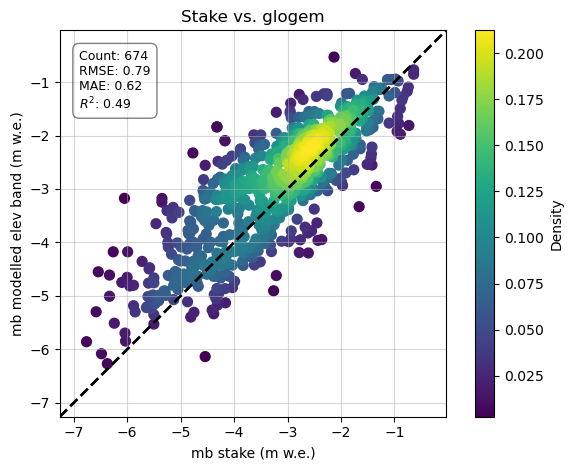

In [59]:
# TEST PLOT
plot_point_modelled(df_test_summer, 'glogem', 1980, 2019)

## Get ML-model predictions

In [205]:
# Model trained on cluster using up to 0.2 for learning rate. 
# Learning rate [0.01, 0.1, 0.2]
# Max depth [2, 4, 6]
# n_estimators [50, 100, 200, 300]
#with open('Training_cluster/2024-07-10_20-37-03/custom_loss_cv_grid.pkl', 'rb') as f:
#    clf_loaded = pickle.load(f)

# Model trained on cluster using extended grid search (after implementing custom loss funciton performance improvement)
# param_ranges = {'max_depth': [4, 5, 6, 7, 8], # Depth of tree
#                'n_estimators': [200, 300, 400, 500, 600, 700], # Number of trees (too many = overfitting, too few = underfitting)
#                'learning_rate': [0.1, 0.15, 0.2, 0.25], #[0,1]
#with open('Training_cluster/2024-08-06_12-07-32/custom_loss_cv_grid.pkl', 'rb') as f:
#    clf_loaded = pickle.load(f)

# Model trained on cluster using folds split on cycle of years and skyview factor as feature - USING ALL ANNUAL, SUMMER, WINTER DATA
#with open('Training_cluster/2024-10-24_10-30-28/custom_loss_cv_grid.pkl', 'rb') as f:
#    clf_loaded = pickle.load(f)

# Model trained on cluster using folds split on cycle of years and skyview factor as feature - USING ALL ANNUAL AND WINTER DATA
with open('Training_cluster/2024-10-25_09-45-30/custom_loss_cv_grid.pkl', 'rb') as f:
    clf_loaded = pickle.load(f)


best_model = clf_loaded.best_estimator_
#best_model = CustomXGBRegressor(max_depth=5, learning_rate=0.05, n_estimators=200, gamma=0, random_state=23, min_child_weight=0)
#best_model.fit(X_train, y_train)

In [206]:
best_model

CustomXGBRegressor(base_score=None, booster=None, callbacks=None,
                   colsample_bylevel=None, colsample_bynode=None,
                   colsample_bytree=None, device=None,
                   early_stopping_rounds=None, enable_categorical=False,
                   eval_metric=None, feature_types=None, gamma=0,
                   grow_policy=None, importance_type=None,
                   interaction_constraints=None, learning_rate=0.05,
                   max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                   max_delta_step=None, max_depth=3, max_leaves=None,
                   min_child_weight=5, missing=nan, monotone_constraints=None,
                   multi_strategy=None, n_estimators=500, n_jobs=None,
                   num_parallel_tree=None,
                   objective=<function CustomXGBRegressor.fit.<locals>.custom_objective at 0x000002CCB3504A60>, ...)

C:\Users\kasj\AppData\Local\anaconda3\envs\ML_MB_Norway_envi\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\kasj\AppData\Local\anaconda3\envs\ML_MB_Norway_envi\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


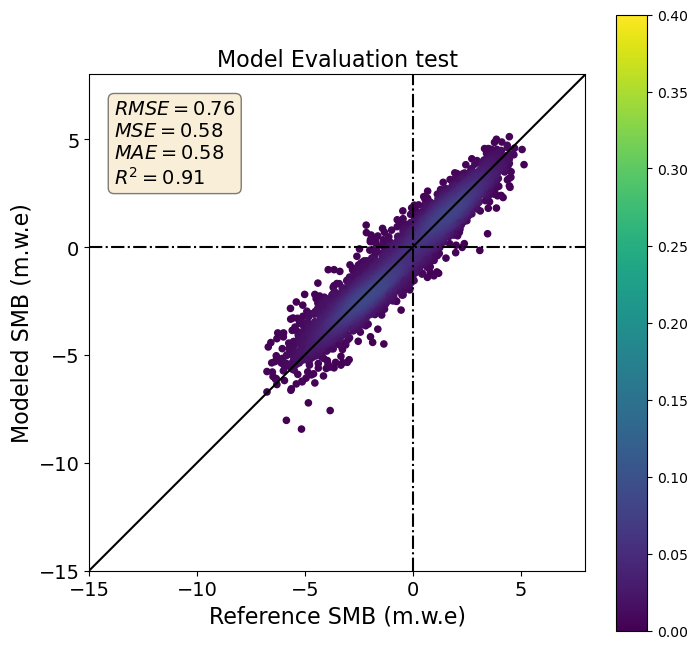

In [207]:
test_pred = best_model.predict(X_test)

# Get test true values and predictions
y_test_mean, y_test_pred_agg = get_ytrue_y_pred_agg(y_test,test_pred,X_test)

# Plot predictions vs true values for test
plot_prediction(y_test_mean, y_test_pred_agg, data_type='test')

In [208]:
y_test_winter, y_pred_winter = get_prediction_per_season_test(X_test, y_test, best_model, months=7)
winter_indices = X_test[:, -2] == 7
X_test_winter = X_test[winter_indices]
y_test_winter_mean, y_pred_winter_agg = get_ytrue_y_pred_agg_season(y_test_winter, y_pred_winter, X_test_winter, months=7)
#plot_prediction_per_season(y_test_winter_mean, y_pred_winter_agg, season='Winter')

df_test_winter['mb_ML'] = y_pred_winter_agg

In [209]:
df_test_winter

BREID  year  altitude_diff  altitude  altitude_climate  balance  \
0      54.0  2013    -129.772081     471.0        341.227919     1.32   
1      54.0  2014     -97.772081     439.0        341.227919     1.68   
2      54.0  2015    -102.772081     444.0        341.227919     0.76   
3      54.0  2016    -102.772081     444.0        341.227919     0.78   
4      54.0  2017    -126.772081     468.0        341.227919     1.59   
..      ...   ...            ...       ...               ...      ...   
994  3141.0  2012    -160.580241    1078.0        917.419759     1.50   
995  3141.0  2013    -160.580241    1078.0        917.419759     1.14   
996  3141.0  2015    -161.580241    1079.0        917.419759     1.19   
997  3141.0  2016    -160.580241    1078.0        917.419759     1.72   
998  3141.0  2017    -160.580241    1078.0        917.419759     1.15   

       aspect     slope  skyview_factor  n_months  ...           slhf  \
0    0.629597  0.278773        0.778997       7.0  ...   62438.500000   
1    0.585924  0.296590        0.798494       7.0  ...   65465.714286   
2    0.663261  0.302508        0.803510       7.0  ...   21334.214286   
3    0.663261  0.302508        0.803510       7.0  ...  102229.642857   
4    0.836757  0.309196        0.817480       7.0  ...   64772.571429   
..        ...       ...             ...       ...  ...            ...   
994  2.906044  0.131717        0.932281       7.0  ... -171713.642857   
995  2.906044  0.131717        0.932281       7.0  ... -123023.142857   
996  2.906044  0.131717        0.932281       7.0  ... -271647.642857   
997  2.906044  0.131717        0.932281       7.0  ... -251040.928571   
998  2.906044  0.131717        0.932281       7.0  ... -255928.142857   

             ssrd       fal           str        tp    ID  mb_glogem  \
0    3.477078e+06  0.749392 -2.148801e+06  0.003397  1258      1.226   
1    3.052352e+06  0.758143 -2.145037e+06  0.003847  1258        NaN   
2    3.186665e+06  0.750785 -2.258321e+06  0.002979  1258      1.055   
3    3.540237e+06  0.771447 -2.084224e+06  0.003243  1258      0.773   
4    3.494867e+06  0.679859 -2.391737e+06  0.003806  1258      1.073   
..            ...       ...           ...       ...   ...        ...   
994  4.804682e+06  0.683440 -1.769234e+06  0.010046  2969      1.795   
995  5.492646e+06  0.711911 -2.165743e+06  0.006262  2969      1.639   
996  4.664342e+06  0.653273 -1.837262e+06  0.011195  2969      1.681   
997  5.058185e+06  0.655849 -1.987646e+06  0.009280  2969      2.123   
998  4.882558e+06  0.674844 -1.963044e+06  0.008427  2969      1.972   

      mb_oggm  mb_pygem     mb_ML  
0    1.777994  1.783696  1.165704  
1    1.695268       NaN  0.998949  
2    1.344041       NaN  0.757514  
3    1.674745       NaN  1.364271  
4    1.803798       NaN  1.077757  
..        ...       ...       ...  
994  2.973974       NaN  2.434563  
995  2.020106       NaN  1.331619  
996  2.814881       NaN  2.156943  
997  2.788278       NaN  2.089067  
998  2.333989       NaN  1.788832  

[999 rows x 22 columns]

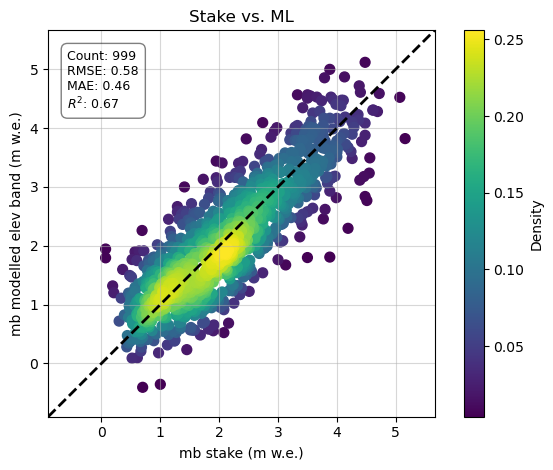

In [210]:
plot_point_modelled(df_test_winter, 'ML', 1959, 2022)

In [211]:
df_test_summer

BREID  year  altitude_diff  altitude  altitude_climate  balance  \
0       54.0  2013    -129.772081     471.0        341.227919    -6.24   
1       54.0  2014     -97.772081     439.0        341.227919    -4.35   
2       54.0  2015    -102.772081     444.0        341.227919    -4.17   
3       54.0  2016    -102.772081     444.0        341.227919    -4.37   
4       54.0  2017    -126.772081     468.0        341.227919    -4.05   
...      ...   ...            ...       ...               ...      ...   
1023  3141.0  2012    -160.580241    1078.0        917.419759    -3.57   
1024  3141.0  2013    -160.580241    1078.0        917.419759    -4.29   
1025  3141.0  2015    -161.580241    1079.0        917.419759    -3.80   
1026  3141.0  2016    -160.580241    1078.0        917.419759    -4.38   
1027  3141.0  2017    -160.580241    1078.0        917.419759    -4.44   

        aspect     slope  skyview_factor  n_months  ...        slhf  \
0     0.629597  0.278773        0.778997       5.0  ... -2949888.30   
1     0.585924  0.296590        0.798494       5.0  ... -2240188.45   
2     0.663261  0.302508        0.803510       5.0  ... -2382853.60   
3     0.663261  0.302508        0.803510       5.0  ... -2698309.70   
4     0.836757  0.309196        0.817480       5.0  ... -1884445.15   
...        ...       ...             ...       ...  ...         ...   
1023  2.906044  0.131717        0.932281       5.0  ... -1724419.25   
1024  2.906044  0.131717        0.932281       5.0  ... -2503409.00   
1025  2.906044  0.131717        0.932281       5.0  ... -1079567.30   
1026  2.906044  0.131717        0.932281       5.0  ... -2213228.25   
1027  2.906044  0.131717        0.932281       5.0  ... -2222112.90   

            ssrd       fal         str        tp    ID  mb_glogem   mb_oggm  \
0     14333271.4  0.234405 -4096567.90  0.002866  1258     -5.511 -5.881738   
1     14340004.3  0.343329 -3613599.05  0.002707  1258        NaN -4.654542   
2     13163506.1  0.284936 -3492518.15  0.003367  1258     -4.864 -4.283437   
3     12194028.9  0.217927 -3390287.60  0.002925  1258     -4.975 -5.313028   
4     13869421.1  0.341601 -3293730.55  0.003186  1258     -3.282 -4.154375   
...          ...       ...         ...       ...   ...        ...       ...   
1023  14346574.6  0.356145 -2481046.90  0.006822  2969     -3.397 -4.830727   
1024  14099480.7  0.302352 -2946410.05  0.006346  2969     -4.962 -5.690383   
1025  14448706.6  0.430668 -1973078.45  0.006524  2969     -2.404 -4.520886   
1026  13748145.0  0.285253 -2613071.80  0.007863  2969     -4.635 -5.891730   
1027  13117023.7  0.292764 -2453521.90  0.006619  2969     -3.994 -5.305985   

      mb_pygem     mb_ML  
0    -6.302854 -5.297961  
1          NaN -4.707226  
2          NaN -3.997855  
3          NaN -4.385746  
4          NaN -4.287549  
...        ...       ...  
1023       NaN -3.808799  
1024       NaN -4.611671  
1025       NaN -3.424848  
1026       NaN -5.268450  
1027       NaN -4.700311  

[1028 rows x 22 columns]

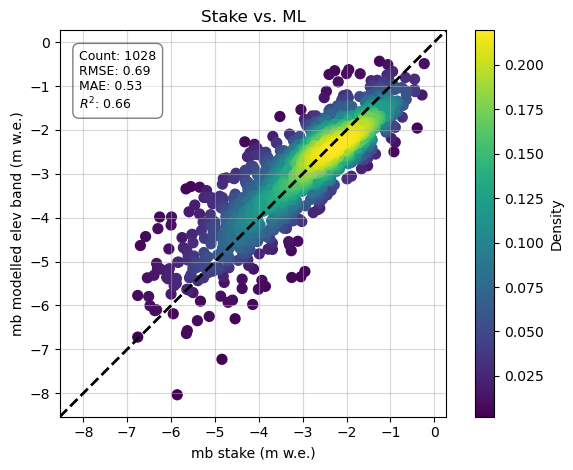

In [213]:
y_test_summer, y_pred_summer = get_prediction_per_season_test(X_test, y_test, best_model, months=5)
summer_indices = X_test[:, -2] == 5
X_test_summer = X_test[summer_indices]
y_test_summer_mean, y_pred_summer_agg = get_ytrue_y_pred_agg_season(y_test_summer, y_pred_summer, X_test_summer, months=5)
#plot_prediction_per_season(y_test_summer_mean, y_pred_summer_agg, season='Summer')

df_test_summer['mb_ML'] = y_pred_summer_agg
plot_point_modelled(df_test_summer, 'ML', 1959, 2022)

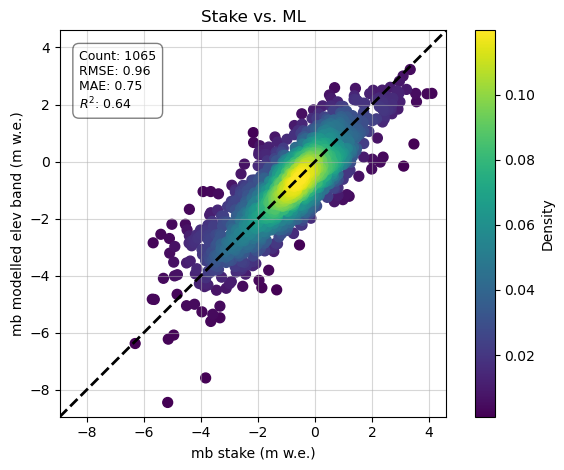

In [214]:
y_test_annual, y_pred_annual = get_prediction_per_season_test(X_test, y_test, best_model, months=12)
annual_indices = X_test[:, -2] == 12
X_test_annual = X_test[annual_indices]
y_test_annual_mean, y_pred_annual_agg = get_ytrue_y_pred_agg_season(y_test_annual, y_pred_annual, X_test_annual, months=12)
#plot_prediction_per_season(y_test_annual_mean, y_pred_annual_agg, season='Annual')

df_test_annual['mb_ML'] = y_pred_annual_agg
plot_point_modelled(df_test_annual, 'ML', 1959, 2022)

## Predict annual mass balance from seasonal mass balance, gives same results

In [215]:
# Predict annual mass balance from sum of seasonal mass balance

# Define the months for each group
winter_months = {'oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr'}
summer_months = {'may', 'jun', 'jul', 'aug', 'sep'}

# Create a boolean mask for each group
winter_mask = np.isin(X_test_annual[:, -1], list(winter_months))
summer_mask = np.isin(X_test_annual[:, -1], list(summer_months))

# Create subsets using the masks
X_test_winter_sum = X_test_annual[winter_mask]
X_test_summer_sum = X_test_annual[summer_mask]

# Modify the second to last column for each subset
X_test_winter_sum[:, -2] = 7
X_test_summer_sum[:, -2] = 5

# Dummies
y_test_winter_sum = y_test_annual[winter_mask]
y_test_summer_sum = y_test_annual[summer_mask]
#y_test_winter_sum[:, -2] = 7
#y_test_summer_sum[:, -2] = 5

In [216]:
test_winter_sum_pred = best_model.predict(X_test_winter_sum)
test_summer_sum_pred = best_model.predict(X_test_summer_sum)

In [217]:
# Get test true values and predictions
y_test_winter_sum_mean, y_pred_winter_sum_agg = get_ytrue_y_pred_agg(y_test_winter_sum,test_winter_sum_pred,X_test_winter_sum)
y_test_summer_sum_mean, y_pred_summer_sum_agg = get_ytrue_y_pred_agg(y_test_summer_sum,test_summer_sum_pred,X_test_summer_sum)


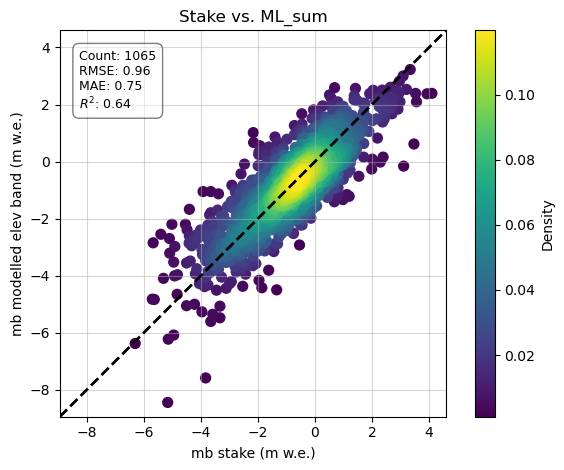

In [218]:
df_test_annual['mb_ML_sum'] = y_pred_winter_sum_agg + y_pred_summer_sum_agg
plot_point_modelled(df_test_annual, 'ML_sum', 1959, 2022)

In [219]:
df_test_annual[['mb_ML','mb_ML_sum']]

mb_ML  mb_ML_sum
0    -4.006602  -4.006602
1    -3.290628  -3.290628
2    -3.268812  -3.268812
3    -3.447045  -3.447045
4    -3.026467  -3.026467
...        ...        ...
1060 -1.390846  -1.390846
1061 -3.161398  -3.161398
1062 -1.660244  -1.660244
1063 -3.311808  -3.311808
1064 -2.896966  -2.896966

[1065 rows x 2 columns]

In [220]:
sum(df_test_annual['mb_pygem'].isna())

257

## Plot modelled point mass balance against observed point mass balance for all models

In [236]:
# PLOT POINTS WITH GAUSSIAN KDE (WORKS ONLY FOR COMMON TIME PERIOD DUE TO SORTING)
# Three dataframes that only contain predictions for test glaciers:
# df_test_annual
# df_test_winter
# df_test_summer

# Each df contains the following columns: 
# year, balance, mb_glogem, mb_oggm, mb_pygem, mb_ML

# Set the start and end years for the filter
start_year = 1980
end_year = 2019

gl = 'all'

# Function to filter DataFrame based on year range
def filter_df_by_year(df, start_year, end_year):
    return df[(df['year'] >= start_year) & (df['year'] <= end_year)]

# Filter the DataFrames
#df_obs_nonan = df_obs.dropna(subset=['RGIID'])
if gl == 'test':
    print('test')
    #df_obs_nonan = filter_df_by_rgiid_and_year(df_obs_nonan, test_glaciers, start_year, end_year)
    #df_pred_filtered = filter_df_by_rgiid_and_year(df_pred, test_glaciers, start_year, end_year)
    #df_oggm_filtered = filter_df_by_rgiid_and_year(df_oggm, test_glaciers, start_year, end_year)
    #df_glogem_filtered = filter_df_by_rgiid_and_year(df_glogem, test_glaciers, start_year, end_year)
    #df_pygem_filtered = filter_df_by_rgiid_and_year(df_pygem, test_glaciers, start_year, end_year)
elif gl == 'all':
    df_annual_filtered = filter_df_by_year(df_test_annual, start_year, end_year)
    df_winter_filtered = filter_df_by_year(df_test_winter, start_year, end_year)
    df_summer_filtered = filter_df_by_year(df_test_summer, start_year, end_year)

# List of model columns and corresponding labels
#models = [('mb_ML', 'XGBoost')]
models = [('mb_ML', 'XGBoost'), ('mb_oggm', 'OGGM'), ('mb_glogem', 'GloGEM'), ('mb_pygem', 'PyGEM')]

def remove_nan_rows(df, model_cols):
    """Remove rows with NaNs in the 'balance' column or any of the model columns."""
    columns_to_check = ['balance'] + model_cols
    return df.dropna(subset=columns_to_check)



In [237]:
# List of model columns
#model_cols = ['mb_ML']
model_cols = ['mb_ML', 'mb_oggm', 'mb_glogem', 'mb_pygem']

# Filter DataFrames to remove rows with NaNs in relevant columns
df_annual_filtered = remove_nan_rows(df_annual_filtered, model_cols)
df_winter_filtered = remove_nan_rows(df_winter_filtered, model_cols)
df_summer_filtered = remove_nan_rows(df_summer_filtered, model_cols)


In [238]:
# Step 1: Add a 'Type' Column to Each DataFrame
df_annual_filtered['Type'] = 'Ba'
df_winter_filtered['Type'] = 'Bw'
df_summer_filtered['Type'] = 'Bs'

# Step 2: Concatenate the DataFrames into One
combined_df = pd.concat([df_annual_filtered, df_winter_filtered, df_summer_filtered], ignore_index=True)

# Calculate the point density
def gaussian_kde_plot(x_,y_):
    xy = np.vstack([x_,y_])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = x_[idx], y_[idx], z[idx]
    return x, y, z

from matplotlib.colors import ListedColormap
my_cmap_blue = sns.dark_palette('tab:blue', n_colors=8, as_cmap=True, reverse=True)
my_cmap_red = sns.dark_palette('tab:red', n_colors=8, as_cmap=True, reverse=True)
my_cmap_black = sns.dark_palette('grey', n_colors=8, as_cmap=True, reverse=True)
my_alpha = 0.5

cm=1/2.54
fontsize = 8
fontsize_small = 8.0
fontsize_min = 8.0
markersize = 20
subplot_labels = ['(a)', '(b)', '(c)', '(d)']

In [239]:
combined_df

BREID  year  altitude_diff  altitude  altitude_climate  balance  \
0       54.0  2013    -129.772081     471.0        341.227919    -4.92   
1       54.0  2018    -133.772081     475.0        341.227919    -4.37   
2       54.0  1997    -138.772081     480.0        341.227919    -2.85   
3       54.0  2001    -137.772081     479.0        341.227919    -3.69   
4       54.0  2003    -115.772081     457.0        341.227919    -2.66   
...      ...   ...            ...       ...               ...      ...   
1589  3141.0  2013    -175.967311    1222.0       1046.032689    -3.83   
1590  3141.0  2014    -174.967311    1221.0       1046.032689    -4.75   
1591  3141.0  2015    -174.967311    1221.0       1046.032689    -3.06   
1592  3141.0  2009    -164.580241    1082.0        917.419759    -4.16   
1593  3141.0  2010    -164.580241    1082.0        917.419759    -3.26   

        aspect     slope  skyview_factor  n_months  ...       fal  \
0     0.629597  0.278773        0.778997      12.0  ...  0.534814   
1     0.871247  0.293749        0.813543      12.0  ...  0.535598   
2     0.914653  0.137994        0.758399      12.0  ...  0.603610   
3     0.775073  0.212720        0.767931      12.0  ...  0.542054   
4     0.587371  0.223665        0.780498      12.0  ...  0.596653   
...        ...       ...             ...       ...  ...       ...   
1589  3.090626  0.052604        0.976025       5.0  ...  0.759925   
1590  3.032440  0.060314        0.983040       5.0  ...  0.756143   
1591  3.032440  0.060314        0.983040       5.0  ...  0.782933   
1592  2.906044  0.131717        0.932281       5.0  ...  0.299276   
1593  2.906044  0.131717        0.932281       5.0  ...  0.248455   

               str        tp    ID  mb_glogem   mb_oggm  mb_pygem     mb_ML  \
0    -2.960371e+06  0.003176  1258     -4.285 -4.103744 -4.519159 -4.006602   
1    -2.749480e+06  0.003266  1258     -4.069 -3.813573 -4.330744 -3.485594   
2    -2.776794e+06  0.003198  1258     -2.135 -2.400137 -2.262478 -2.719407   
3    -2.677465e+06  0.003104  1258     -3.852 -3.059509 -3.804986 -2.852058   
4    -2.840452e+06  0.003283  1258     -2.747 -2.444564 -2.739592 -3.142845   
...            ...       ...   ...        ...       ...       ...       ...   
1589 -5.134835e+05  0.006548  2969     -4.430 -4.758966 -4.867850 -2.767809   
1590 -6.912250e+05  0.005503  2969     -4.347 -5.390486 -5.698831 -4.035597   
1591 -6.737656e+05  0.006596  2969     -2.039 -3.601678 -2.821063 -2.439362   
1592 -3.105960e+06  0.007986  2969     -5.129 -5.887157 -6.024286 -4.483264   
1593 -4.190417e+06  0.005179  2969     -4.904 -5.041129 -5.850425 -4.752531   

      mb_ML_sum  Type  
0     -4.006602    Ba  
1     -3.485594    Ba  
2     -2.719407    Ba  
3     -2.852058    Ba  
4     -3.142846    Ba  
...         ...   ...  
1589        NaN    Bs  
1590        NaN    Bs  
1591        NaN    Bs  
1592        NaN    Bs  
1593        NaN    Bs  

[1594 rows x 24 columns]

In [240]:
# Calculate RMSE, MSE, and bias

metrics = {}
labels = ['XGBoost', 'OGGM', 'GloGEM', 'PyGEM']

print('Metrics based on period :')
print(str(start_year))
print(str(end_year))

for idx, model in enumerate(model_cols):
    label = labels[idx]

    metrics[label] = {}

    for metric in ['Ba', 'Bw', 'Bs']:
        modeled = combined_df[combined_df['Type']==metric][model].values
        observed = combined_df[combined_df['Type']==metric]['balance'].values 
        rmse = root_mean_squared_error(observed, modeled)
        mse = mean_squared_error(observed, modeled)
        mae = np.mean(abs(modeled - observed))
        bias = np.mean(modeled - observed)
        r2 = r2_score(observed, modeled) 
        count = len(observed)  # Count valid pairs
        
        metrics[label][metric] = {'rmse': rmse, 'mse': mse, 'mae': mae, 'bias': bias, 'r2':r2, 'count': count}

        print(f'{label} - {metric}: RMSE={rmse:.2f}, MSE={mse:.2f}, MAE={mae:.2f}, Bias={bias:.2f}, R²={r2:.2f}, Count={count}')


Metrics based on period :
1980
2019
XGBoost - Ba: RMSE=0.95, MSE=0.91, MAE=0.76, Bias=0.00, R²=0.66, Count=561
XGBoost - Bw: RMSE=0.55, MSE=0.30, MAE=0.44, Bias=-0.06, R²=0.67, Count=517
XGBoost - Bs: RMSE=0.69, MSE=0.47, MAE=0.54, Bias=0.10, R²=0.70, Count=516
OGGM - Ba: RMSE=0.93, MSE=0.86, MAE=0.73, Bias=0.02, R²=0.68, Count=561
OGGM - Bw: RMSE=0.82, MSE=0.68, MAE=0.63, Bias=0.26, R²=0.26, Count=517
OGGM - Bs: RMSE=0.89, MSE=0.79, MAE=0.72, Bias=-0.27, R²=0.49, Count=516
GloGEM - Ba: RMSE=0.91, MSE=0.83, MAE=0.71, Bias=-0.02, R²=0.69, Count=561
GloGEM - Bw: RMSE=0.65, MSE=0.42, MAE=0.51, Bias=-0.35, R²=0.55, Count=517
GloGEM - Bs: RMSE=0.79, MSE=0.62, MAE=0.61, Bias=0.29, R²=0.60, Count=516
PyGEM - Ba: RMSE=1.05, MSE=1.09, MAE=0.81, Bias=0.36, R²=0.59, Count=561
PyGEM - Bw: RMSE=0.87, MSE=0.76, MAE=0.69, Bias=0.59, R²=0.17, Count=517
PyGEM - Bs: RMSE=0.93, MSE=0.87, MAE=0.75, Bias=-0.27, R²=0.44, Count=516


In [241]:
# Calculate the point density
def gaussian_kde_plot(x_,y_):
    xy = np.vstack([x_,y_])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = x_[idx], y_[idx], z[idx]
    return x, y, z

from matplotlib.colors import ListedColormap
my_cmap_blue = sns.dark_palette('tab:blue', n_colors=8, as_cmap=True, reverse=True)
my_cmap_red = sns.dark_palette('tab:red', n_colors=8, as_cmap=True, reverse=True)
my_cmap_black = sns.dark_palette('grey', n_colors=8, as_cmap=True, reverse=True)
my_alpha = 0.5

cm=1/2.54
fontsize = 8
fontsize_small = 8.0
fontsize_min = 8.0
markersize = 20
subplot_labels = ['(a)', '(b)', '(c)', '(d)']
        

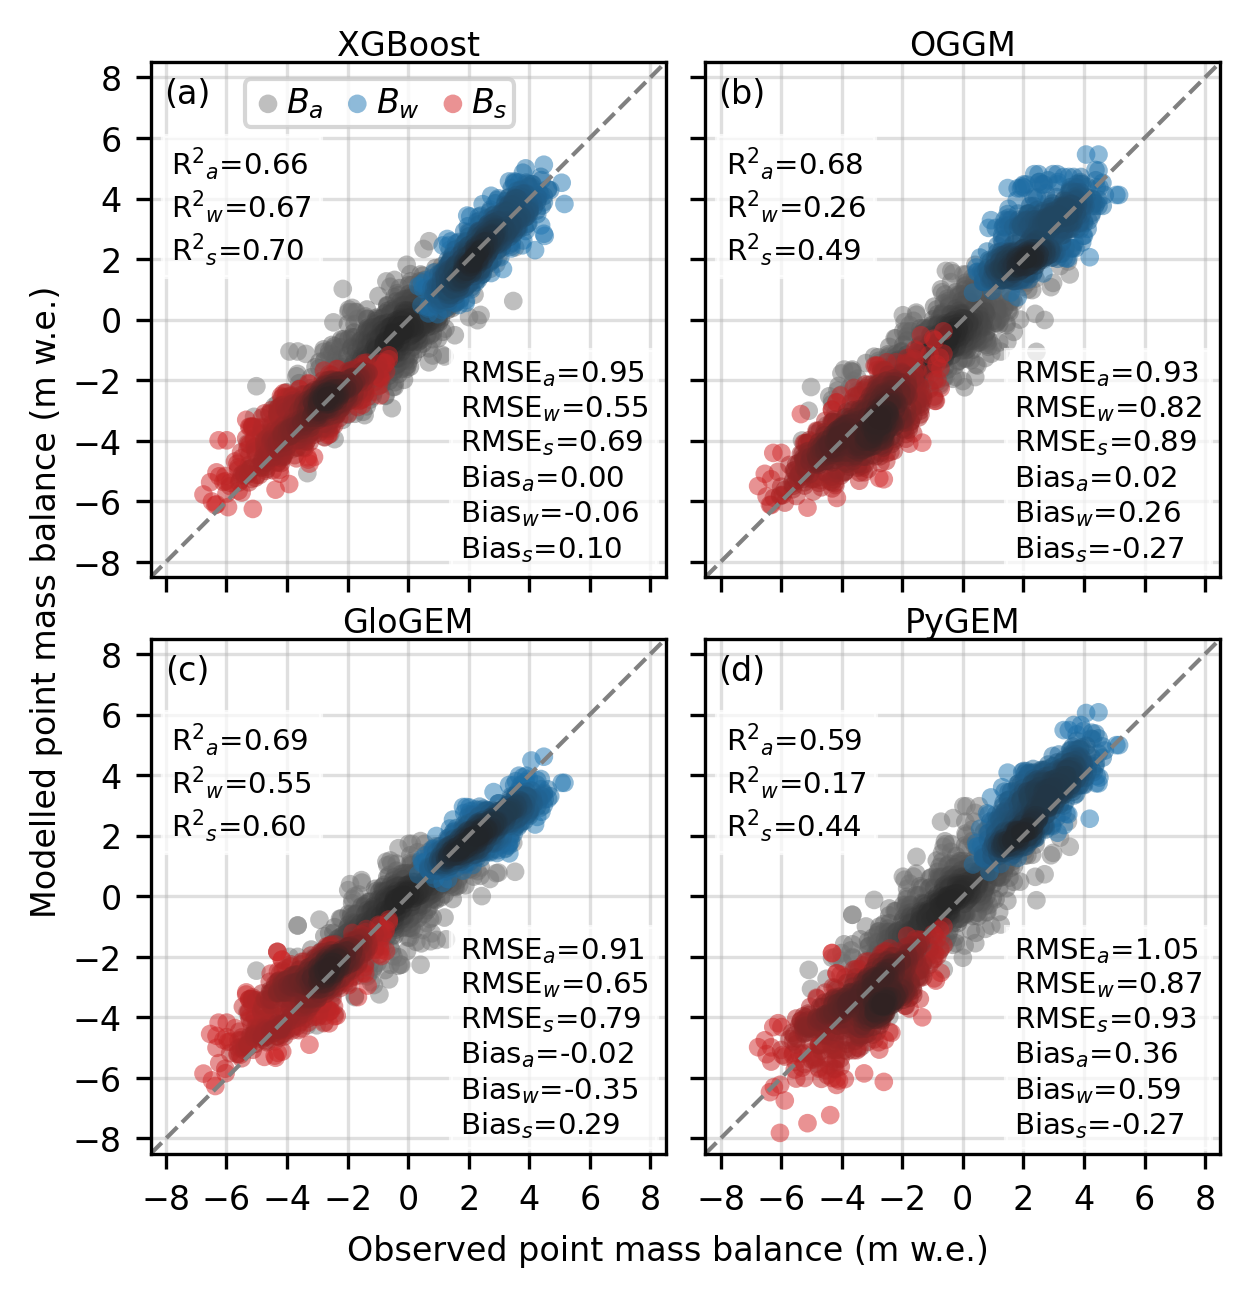

In [242]:
# 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(12*cm, 12*cm), sharex=True, sharey=True, dpi=300)
axs = axs.flatten()

tick_min = -8
tick_max = 8
ticks = np.arange(tick_min, tick_max+1, 2)

# model_cols = ['mb_ML', 'mb_oggm', 'mb_glogem', 'mb_pygem']
labels = ['XGBoost', 'OGGM', 'GloGEM', 'PyGEM']

for idx, model in enumerate(model_cols):
    ax = axs[idx]
    label = labels[idx]
    
    for metric in ['Ba', 'Bw', 'Bs']:
        
        y_ = combined_df[combined_df['Type']==metric][model].values
        x_ = combined_df[combined_df['Type']==metric]['balance'].values     
        x, y, z = gaussian_kde_plot(x_, y_)
        
        if metric == 'Ba':
            ax.scatter(x, y, c=z, s=markersize, edgecolors='none', cmap=my_cmap_black, alpha=my_alpha, label=metric)
        elif metric == 'Bw':
            ax.scatter(x, y, c=z, s=markersize, edgecolors='none', cmap=my_cmap_blue, alpha=my_alpha, label=metric)
        elif metric == 'Bs':
            ax.scatter(x, y, c=z, s=markersize, edgecolors='none', cmap=my_cmap_red, alpha=my_alpha, label=metric)

    ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='--', color='gray', linewidth=1)
    ax.set_title(f'{label}', fontsize=fontsize, pad=0.1)
    ax.set_aspect('equal', 'box')
    ax.set_xlim(-8.5, 8.5)
    ax.set_ylim(-8.5, 8.5)
    ax.legend(loc = 'lower right', fontsize=fontsize)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_axisbelow(True)
    ax.grid(alpha=0.4)
    ax.tick_params(axis='both', which='major', labelsize=fontsize_small)
    
    rmse_list = [f"RMSE$_{{{metric[-1]}}}$={metrics[label][metric]['rmse']:.2f}" for metric in ['Ba', 'Bw', 'Bs']]
    mbe_list = [f"Bias$_{{{metric[-1]}}}$={metrics[label][metric]['bias']:.2f}" for metric in ['Ba', 'Bw', 'Bs']]
    textstr = '\n'.join(rmse_list + mbe_list)

    r2_list = [f"R$^2$$_{{{metric[-1]}}}$={metrics[label][metric]['r2']:.2f}" for metric in ['Ba', 'Bw', 'Bs']]
    textstr2 = '\n'.join(r2_list)

    ax.text(0.6, 0.025, textstr, transform=ax.transAxes, fontsize=7, #wrap=True,
            verticalalignment='bottom', bbox=dict(boxstyle='square', color='white', alpha=0.7))
    
    ax.text(0.04, 0.6, textstr2, transform=ax.transAxes, fontsize=7, #wrap=True,
            verticalalignment='bottom', bbox=dict(boxstyle='square', color='white', alpha=0.7))
    
    ax.annotate(subplot_labels[idx], xy=(0.07, 0.97), xycoords='axes fraction', fontsize=fontsize_small,# fontweight='bold',
                ha='center', va='top')
    
    ax.legend().remove()

for ax in axs:
    ax.set_xlabel('')
    ax.set_ylabel('')

axs[0].legend(['$B_{a}$','$B_{w}$','$B_{s}$'],loc = 'upper left', fontsize=fontsize_small, 
              handlelength= 1, handletextpad=0.05,borderpad=0.2,labelspacing=0.2, ncols=3, columnspacing=0.5, bbox_to_anchor=(0.15,1.0))

fig.supxlabel('Observed point mass balance (m w.e.)', fontsize=fontsize, y=0.03)#, labelpad = 16)
fig.supylabel('Modelled point mass balance (m w.e.)', fontsize=fontsize, x=0.05)#, labelpad = 16)

plt.subplots_adjust(wspace=0.02, hspace=0.12)

#pdf_path = 'C:/Users/kasj/OneDrive - Høgskulen på Vestlandet/Projects/2022_ML_for_MB_Norway/Figures_paper/'
#plt.savefig(pdf_path+'comparison_point_test_common_obs_kde.pdf', format='pdf', bbox_inches='tight')

plt.show()

## Point performance XGBoost Model per glacier

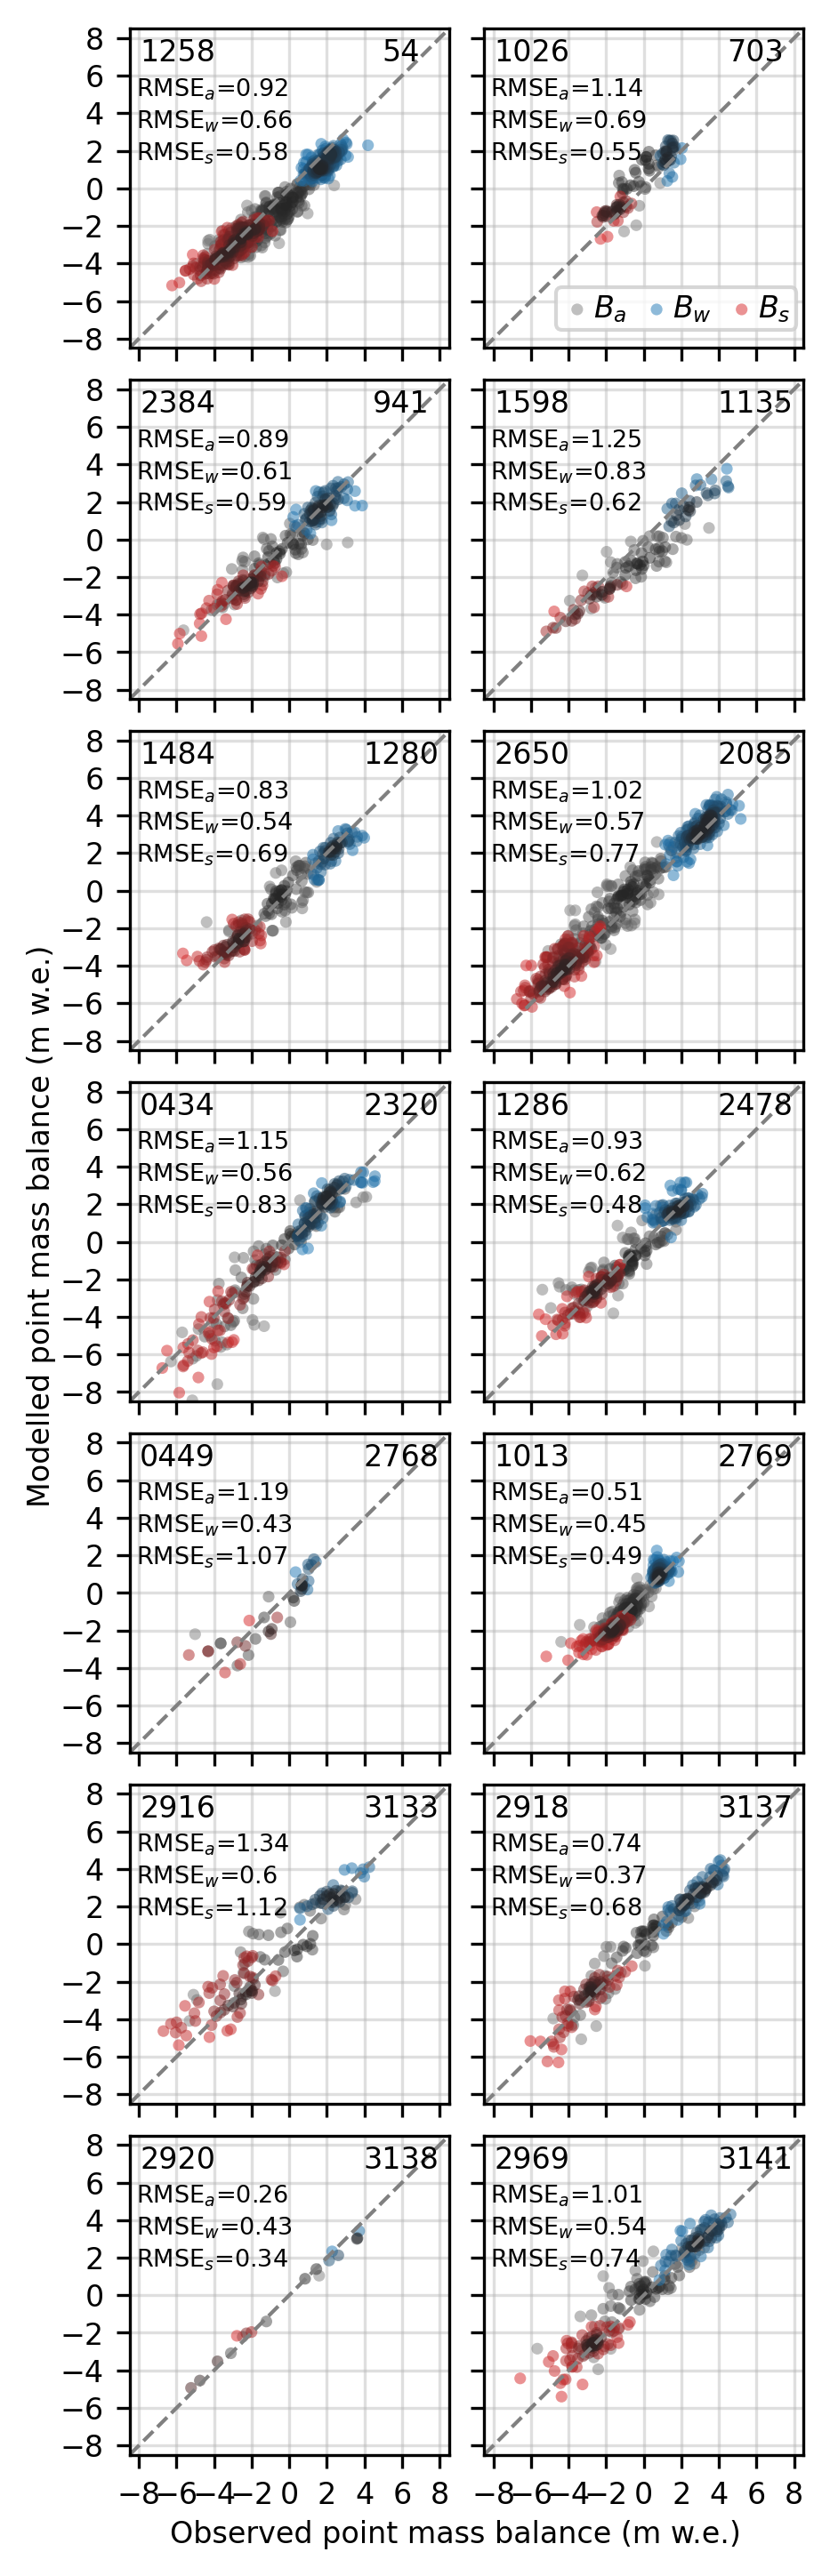

In [228]:
# Should be a 2x7 subplot, because 7 is the number of glaciers

# Calculate the point density
def gaussian_kde_plot(x_,y_):
    xy = np.vstack([x_,y_])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = x_[idx], y_[idx], z[idx]
    return x, y, z

from matplotlib.colors import ListedColormap
my_cmap_blue = sns.dark_palette('tab:blue', n_colors=8, as_cmap=True, reverse=True)
my_cmap_red = sns.dark_palette('tab:red', n_colors=8, as_cmap=True, reverse=True)
my_cmap_black = sns.dark_palette('grey', n_colors=8, as_cmap=True, reverse=True)
my_alpha = 0.5

cm=1/2.54
fontsize = 8
fontsize_small = 8.0
fontsize_min = 8.0
markersize = 10
subplot_labels = ['(a)', '(b)', '(c)', '(d)']


fig, axs = plt.subplots(7,2, figsize=(8.5*cm, 30*cm), sharex=True, sharey=True, dpi=300)
axs = axs.flatten()

tick_min = -8
tick_max = 8
ticks = np.arange(tick_min, tick_max+1, 2)

model_cols = ['mb_ML']#, 'mb_oggm', 'mb_glogem', 'mb_pygem']
labels = ['XGBoost']#, 'OGGM', 'GloGEM', 'PyGEM']
glaciers = list(combined_df.ID.unique())
breid = list(combined_df.BREID.unique())

for i in range(0,len(glaciers)):

    glacier = glaciers[i]
    df_glacier = combined_df[combined_df['ID']==glacier]
    ax = axs[i]

    for idx, model in enumerate(model_cols):
        label = labels[idx]

        for metric in ['Ba', 'Bw', 'Bs']:
        
            y_ = df_glacier[df_glacier['Type']==metric][model].values
            x_ = df_glacier[df_glacier['Type']==metric]['balance'].values     
            x, y, z = gaussian_kde_plot(x_, y_)
        
            if metric == 'Ba':
                ax.scatter(x, y, c=z, s=markersize, edgecolors='none', cmap=my_cmap_black, alpha=my_alpha, label=metric)
                rmse = root_mean_squared_error(x_, y_)
                rmse_txt = "RMSE$_{a}$="+str(round(rmse,2))
                ax.annotate(rmse_txt, xy=(0.02, 0.85), xycoords='axes fraction', fontsize=6.5, va='top')
            elif metric == 'Bw':
                ax.scatter(x, y, c=z, s=markersize, edgecolors='none', cmap=my_cmap_blue, alpha=my_alpha, label=metric)
                rmse = root_mean_squared_error(x_, y_)
                rmse_txt = "RMSE$_{w}$="+str(round(rmse,2))
                ax.annotate(rmse_txt, xy=(0.02, 0.75), xycoords='axes fraction', fontsize=6.5, va='top')
            elif metric == 'Bs':
                ax.scatter(x, y, c=z, s=markersize, edgecolors='none', cmap=my_cmap_red, alpha=my_alpha, label=metric)
                rmse = root_mean_squared_error(x_, y_)
                rmse_txt = "RMSE$_{s}$="+str(round(rmse,2))
                ax.annotate(rmse_txt, xy=(0.02, 0.65), xycoords='axes fraction', fontsize=6.5, va='top')

            #rmse = root_mean_squared_error(observed, modeled)
            #mse = mean_squared_error(observed, modeled)
            #mae = np.mean(abs(modeled - observed))
            #bias = np.mean(modeled - observed)
            #r2 = r2_score(observed, modeled) 

        ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='--', color='gray', linewidth=1)
        #ax.set_title(f'{label}', fontsize=fontsize, pad=0.1)
        ax.set_aspect('equal', 'box')
        ax.set_xlim(-8.5, 8.5)
        ax.set_ylim(-8.5, 8.5)
        ax.legend(loc = 'lower right', fontsize=fontsize)
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        ax.set_axisbelow(True)
        ax.grid(alpha=0.4)
        ax.tick_params(axis='both', which='major', labelsize=fontsize_small)
    
        rmse_list = [f"RMSE$_{{{metric[-1]}}}$={metrics[label][metric]['rmse']:.2f}" for metric in ['Ba', 'Bw', 'Bs']]
        mbe_list = [f"Bias$_{{{metric[-1]}}}$={metrics[label][metric]['bias']:.2f}" for metric in ['Ba', 'Bw', 'Bs']]
        textstr = '\n'.join(rmse_list + mbe_list)

        r2_list = [f"R$^2$$_{{{metric[-1]}}}$={metrics[label][metric]['r2']:.2f}" for metric in ['Ba', 'Bw', 'Bs']]
        textstr2 = '\n'.join(r2_list)

        #ax.text(0.6, 0.025, textstr, transform=ax.transAxes, fontsize=7, #wrap=True,
        #        verticalalignment='bottom', bbox=dict(boxstyle='square', color='white', alpha=0.7))
    
        #ax.text(0.04, 0.6, textstr2, transform=ax.transAxes, fontsize=7, #wrap=True,
        #        verticalalignment='bottom', bbox=dict(boxstyle='square', color='white', alpha=0.7))
    
        ax.annotate(glaciers[i], xy=(0.15, 0.97), xycoords='axes fraction', fontsize=fontsize_small,# fontweight='bold',
                    ha='center', va='top')
        ax.annotate(int(breid[i]), xy=(0.85, 0.97), xycoords='axes fraction', fontsize=fontsize_small,# fontweight='bold',
                    ha='center', va='top')
    
        ax.legend().remove()

for ax in axs:
    ax.set_xlabel('')
    ax.set_ylabel('')

axs[1].legend(['$B_{a}$','$B_{w}$','$B_{s}$'],loc = 'lower left', fontsize=fontsize_small, handlelength= 1, handletextpad=0.05,borderpad=0.2,labelspacing=0.2, ncols=3, columnspacing=0.5, bbox_to_anchor=(0.18,0.01))

fig.supxlabel('Observed point mass balance (m w.e.)', fontsize=fontsize, y=0.08)#, labelpad = 16)
fig.supylabel('Modelled point mass balance (m w.e.)', fontsize=fontsize)#, x=0.05)#, labelpad = 16)

plt.subplots_adjust(wspace=0.05, hspace=0.1)

#pdf_path = 'C:/Users/kasj/OneDrive - Høgskulen på Vestlandet/Projects/2022_ML_for_MB_Norway/Figures_paper/'
#plt.savefig(pdf_path+'comparison_point_test_common_obs_kde.pdf', format='pdf', bbox_inches='tight')

plt.show()

## OLD: Plot modelled point mass balance against observed point mass balance for all models

In [47]:
# Plot modelled and observed point mass balances

def plot_point_modelled_subplot(df, model, start_yr, end_yr, ax, min_val=None, max_val=None):
    """
    df : pd.Dataframe of point mb
    type : str, variable in ds; 'netto', 'summer' or 'winter'
    model : str, model name; 'glogem', 'oggm', 'pygem'
    ax: matplotlib Axes object for the subplot
    min_val: float, minimum value for xlim and ylim
    max_val: float, maximum value for xlim and ylim
    """

    df_clean_dropna = df.dropna(subset=['mb_'+model])
    df_clean = df_clean_dropna[(df_clean_dropna['year'] >= start_yr) & (df_clean_dropna['year'] <= end_yr)]

    y_data = df_clean['mb_'+model]
    x_data = df_clean['balance']
    
    xy = np.vstack([x_data, y_data])
    z = gaussian_kde(xy)(xy)

    df_with_density = pd.DataFrame({
        'x': x_data,
        'y': y_data,
        'z': z
    })

    df_with_density.sort_values('z', inplace=True)

    scatter = ax.scatter(df_with_density['x'], df_with_density['y'], c=df_with_density['z'], s=50, cmap='viridis')

    if min_val is None:
        min_val = min(x_data.min(), y_data.min()) - 0.5
    if max_val is None:
        max_val = max(x_data.max(), y_data.max()) + 0.5
    
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='1:1 Line')
    ax.set_aspect('equal', adjustable='box')
    
    ax.set_xlabel('mb stake (m w.e.)')
    ax.set_ylabel('mb modelled elev band (m w.e.)')
    ax.set_title('Stake vs. ' + model)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_data, x_data))
    mse = mean_squared_error(y_data, x_data)
    mae = mean_absolute_error(y_data, x_data) 
    r2 = r2_score(y_data, x_data) 
    bias = np.mean(y_data - x_data)
    count = len(x_data)  # Count the number of data points
    
    stats_text = f'Count: {count}\nRMSE: {rmse:.2f}\nMSE: {mse:.2f}\nMAE: {mae:.2f}\n$R^2$: {r2:.2f}\nBias: {bias:.2f}'
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.5))
    
    plt.colorbar(ax.collections[0], ax=ax, label='')
    ax.grid(alpha=0.5)

In [48]:
def plot_all_models(df, models, start_year, end_year, min_val=None, max_val=None):
    """
    df: DataFrame containing the data
    models: List of model names to plot
    start_year: Start year for filtering data
    end_year: End year for filtering data
    min_val: float, override for min value for xlim and ylim
    max_val: float, override for max value for xlim and ylim
    """
    
    # Create a figure with 4 subplots in one row
    fig, axs = plt.subplots(1, 4, figsize=(20, 5), squeeze=False)
    
    for i, model_name in enumerate(models):
        ax = axs[0, i]  # Access each subplot
        plot_point_modelled_subplot(df, model_name, start_year, end_year, ax, min_val=min_val, max_val=max_val)
        
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

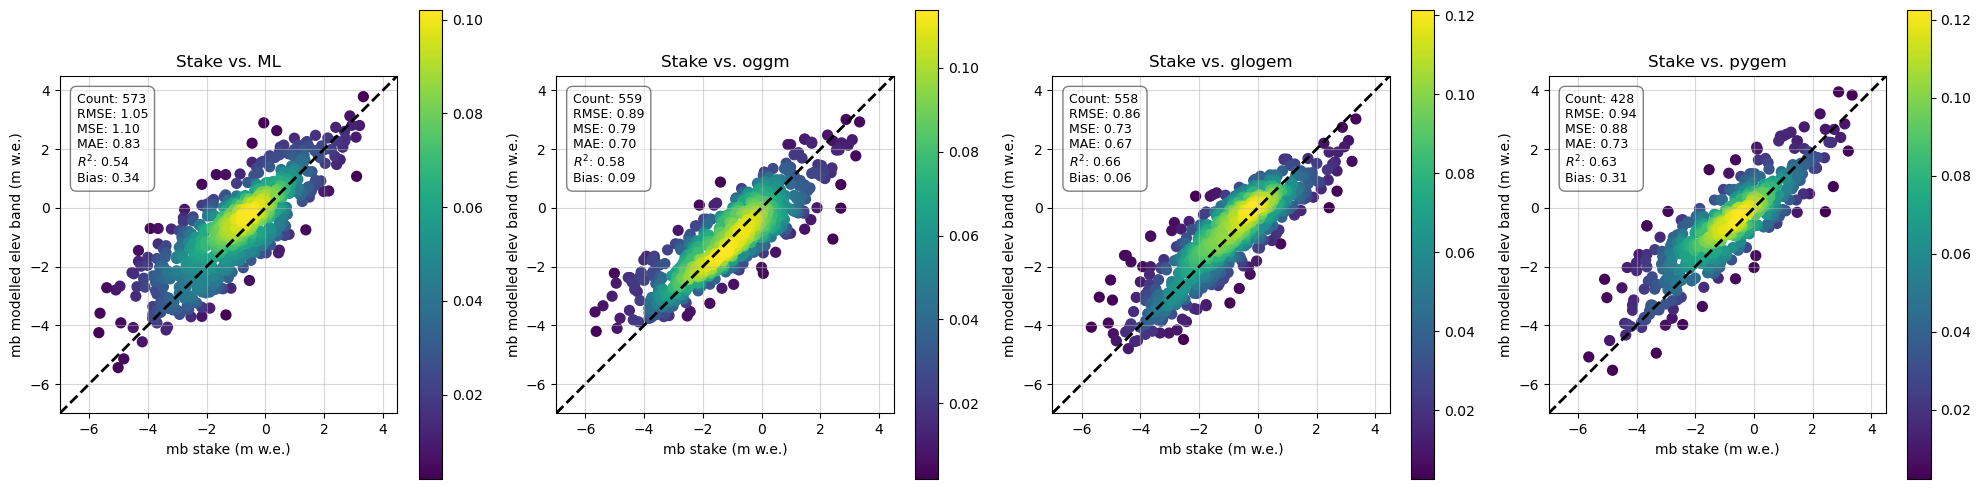

In [49]:
# List of model names
models = ['ML', 'oggm', 'glogem', 'pygem']

plot_all_models(df_test_annual, models, 2000, 2019, min_val=-7, max_val=4.5)

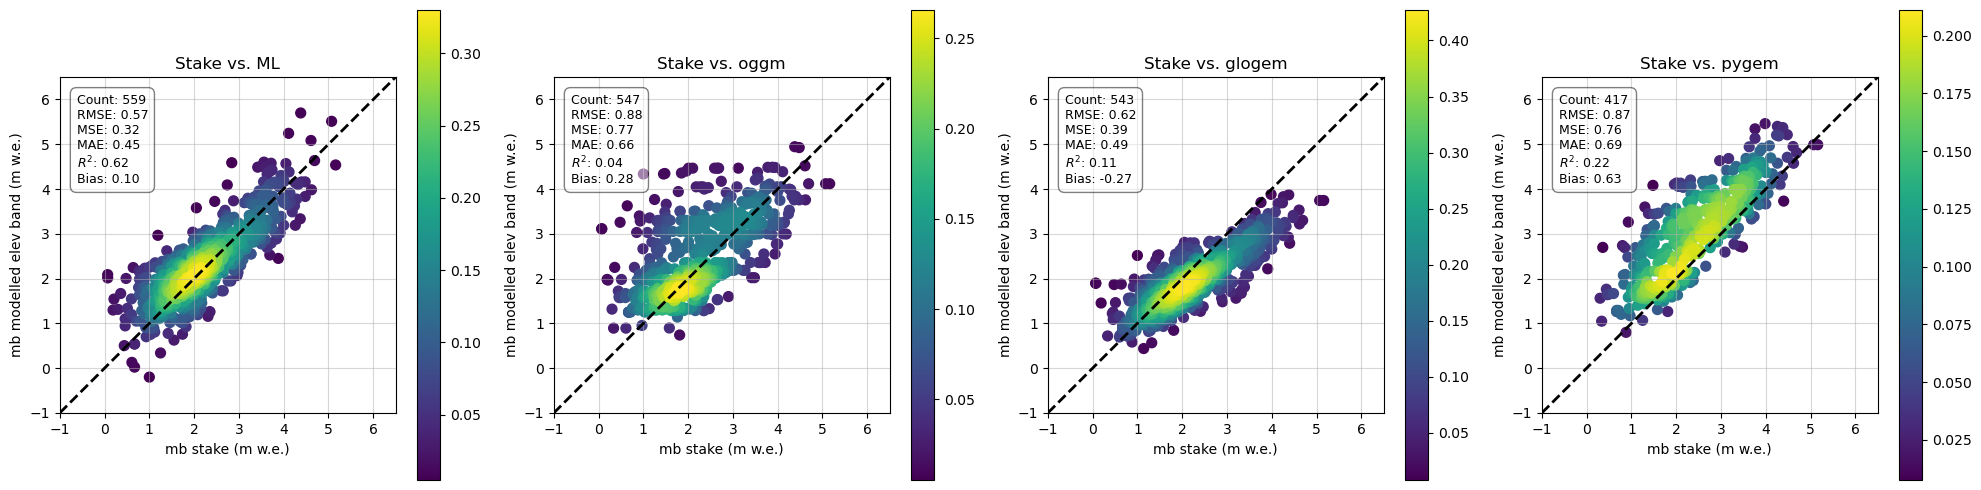

In [50]:
plot_all_models(df_test_winter, models, 2000, 2019, min_val=-1, max_val=6.5)

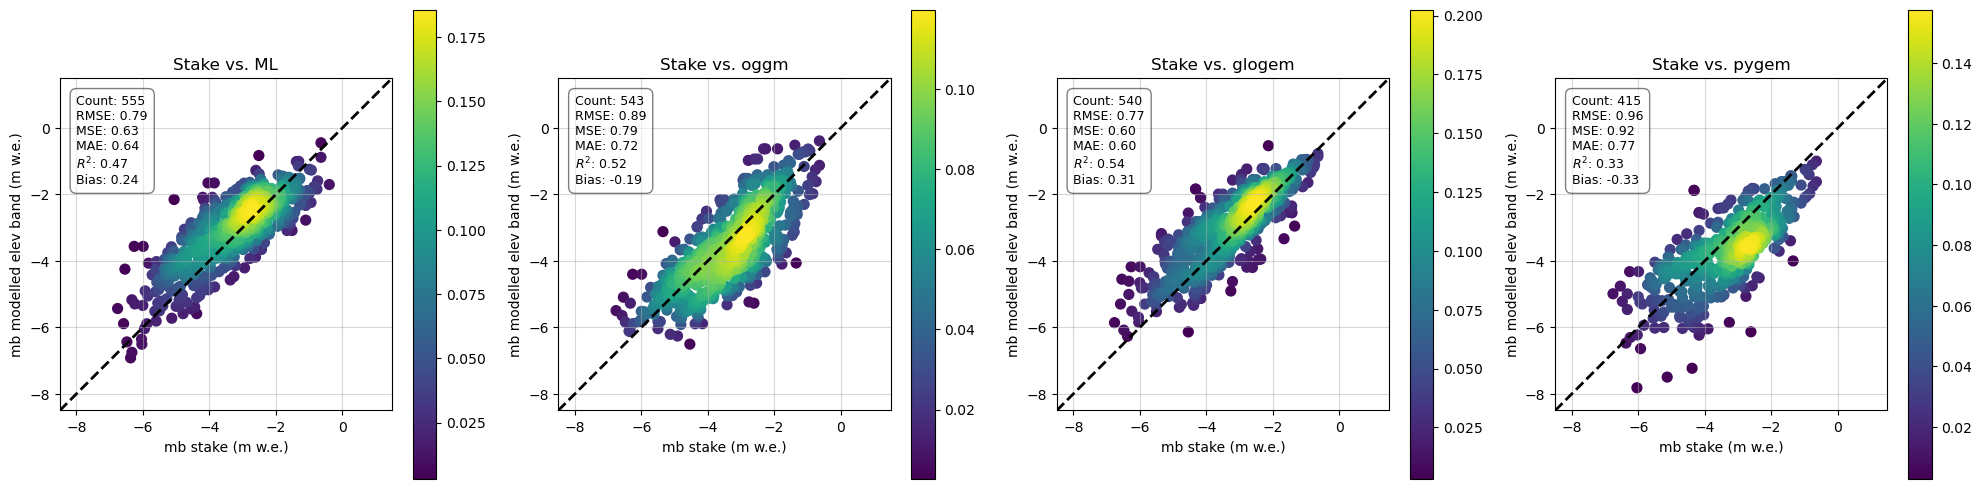

In [51]:
plot_all_models(df_test_summer, models, 2000, 2019, min_val=-8.5, max_val=1.5)

In [52]:
# Filter dataframe with model predictions such that only common values that are not nan are evaluated
# Define the columns to check for NaN values
model_columns = ['mb_ML', 'mb_oggm', 'mb_pygem', 'mb_glogem']

# Filter the DataFrame to select rows where none of the specified columns have NaN values
df_test_annual_nonan = df_test_annual.dropna(subset=model_columns).reset_index(drop=True)
df_test_winter_nonan = df_test_winter.dropna(subset=model_columns).reset_index(drop=True)
df_test_summer_nonan = df_test_summer.dropna(subset=model_columns).reset_index(drop=True)


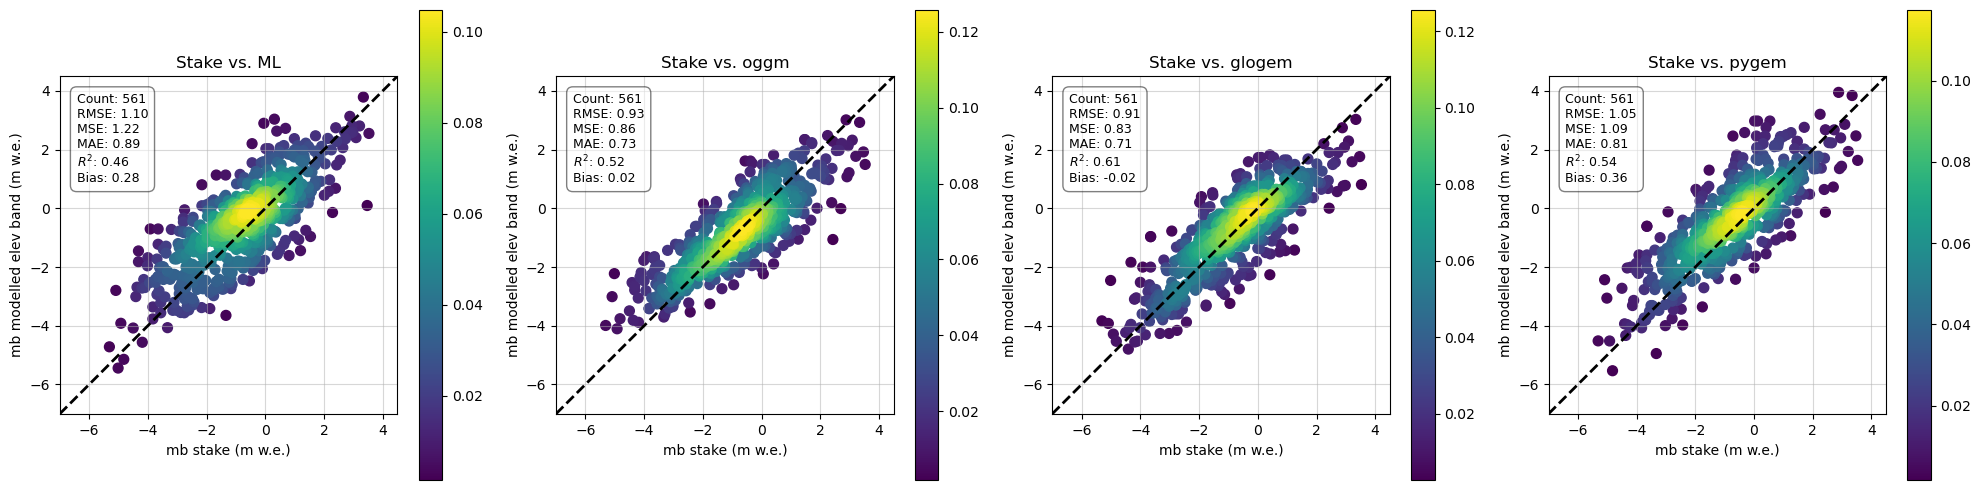

In [53]:
# Annual mb with only common points
plot_all_models(df_test_annual_nonan, models, 1960, 2020, min_val=-7, max_val=4.5)

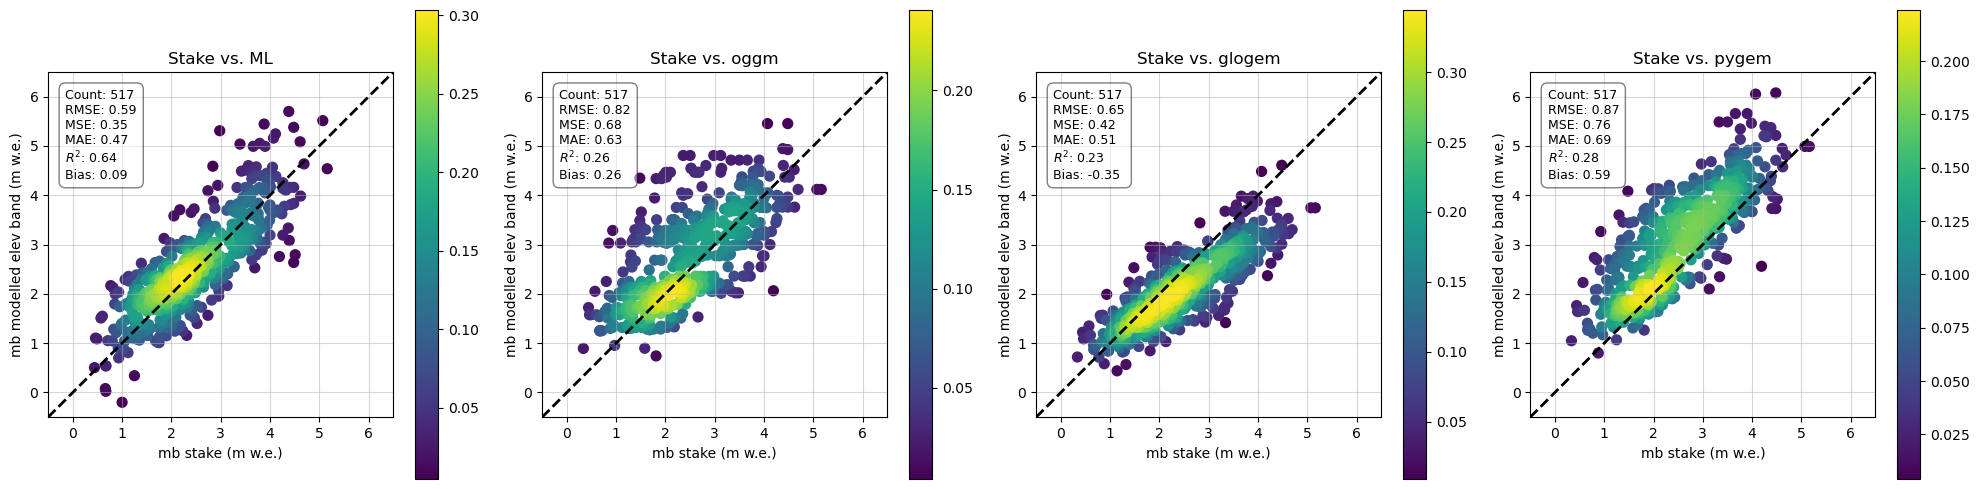

In [54]:
# Winter mb with only common points
plot_all_models(df_test_winter_nonan, models, 1960, 2020, min_val=-0.5, max_val=6.5)

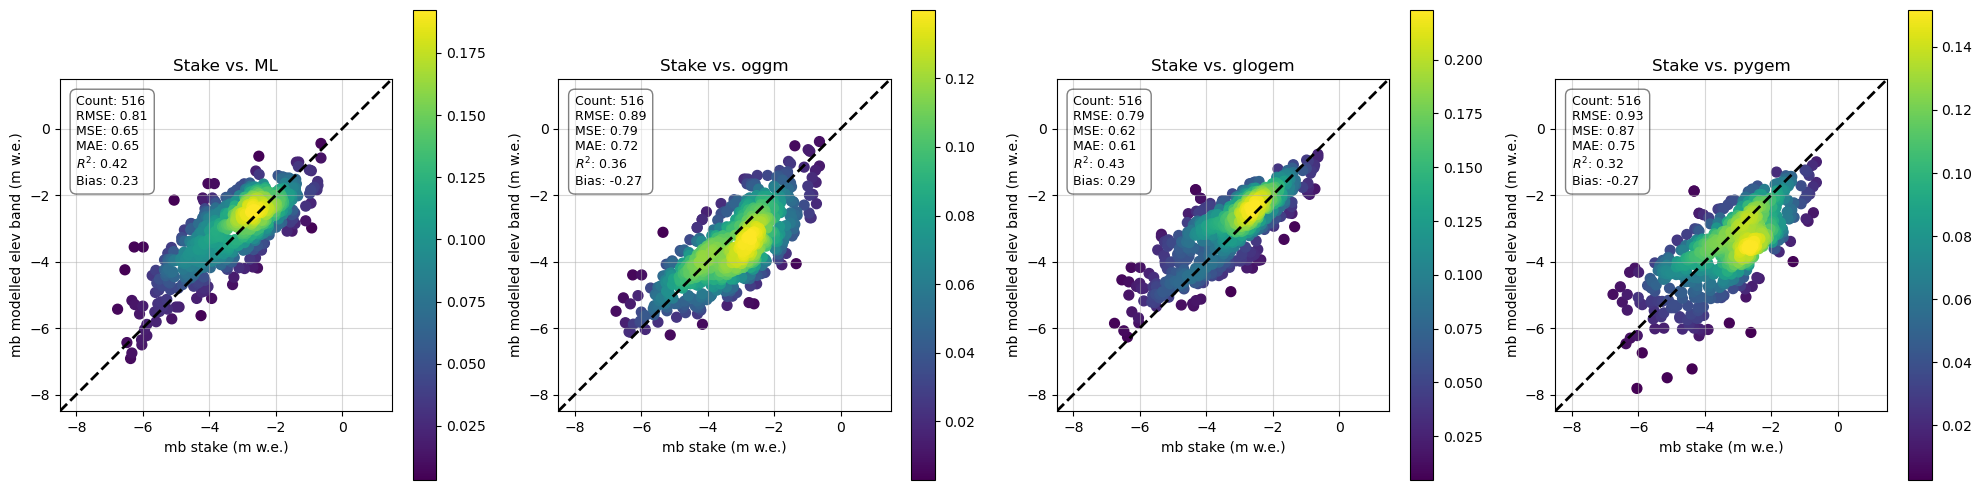

In [55]:
plot_all_models(df_test_summer_nonan, models, 1960, 2020, min_val=-8.5, max_val=1.5)

## Error distributions for point mass balances

In [75]:
# Explore error distribution by BREID, year, and altitude
features_to_explore = ['BREID', 'year', 'altitude']

# Function to group by feature and calculate error statistics
def explore_error_distribution(df, feature):
    grouped = df.groupby(feature).agg({
        'error_ML': ['mean', 'std'],
        'error_oggm': ['mean', 'std'],
        'error_pygem': ['mean', 'std'],
        'error_glogem': ['mean', 'std']
    })
    print(f"\nError distribution grouped by {feature}:")
    print(grouped)

In [76]:
# Function to create box plots
def create_box_plots(df, feature):
    sns.set(style="whitegrid")

    plt.figure(figsize=(14, 8))
    sns.boxplot(x=feature, y='value', hue='variable', 
                data=pd.melt(df, id_vars=[feature], value_vars=['abs_error_ML', 'abs_error_oggm', 'abs_error_pygem', 'abs_error_glogem']))
    plt.title(f'Error Distribution by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Abs. Error')
    plt.xticks(rotation=90)
    plt.legend(title='Model')
    plt.show()

# Function to create violin plots
def create_violin_plots(df, feature):
    sns.set(style="whitegrid")

    plt.figure(figsize=(12, 8))
    sns.violinplot(x=feature, y='value', hue='variable', 
                   data=pd.melt(df, id_vars=[feature], value_vars=['error_ML', 'error_oggm', 'error_pygem', 'error_glogem']), split=False)
    plt.title(f'Error Distribution by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Error')
    plt.legend(title='Model')
    plt.show()

# Function to create histograms
def create_histograms(df):
    sns.set(style="whitegrid")

    df_melted = pd.melt(df, var_name='Model', value_name='Error', value_vars=['error_ML', 'error_oggm', 'error_pygem', 'error_glogem'])
    plt.figure(figsize=(14, 10))
    sns.histplot(data=df_melted, x='Error', hue='Model', kde=True, element='step')
    plt.title('Error Histogram for Each Model')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.show()

def plot_mean_absolute_error_by_year(df, year_col, error_cols, title='Mean Absolute Error by Year for Each Model'):
    """
    Plots the mean absolute error for each model per year with lines connecting the points.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    year_col (str): Column name for the year data.
    error_cols (list of str): List of column names for the absolute error values.
    title (str): Title of the plot. Default is 'Mean Absolute Error by Year for Each Model'.

    """
    # Calculating mean absolute error per year for each model
    mean_abs_error = df.groupby(year_col)[error_cols].mean().reset_index()

    # Melt the DataFrame to long-format for seaborn
    mean_abs_error_melted = pd.melt(mean_abs_error, id_vars=year_col, value_name='MeanAbsError', var_name='Model')

    # Set up the visualization style
    sns.set(style="whitegrid")

    # Plot mean absolute error for each model by year with lines connecting points
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=mean_abs_error_melted, x=year_col, y='MeanAbsError', hue='Model', marker='o')
    plt.title(title)
    plt.xlabel(year_col.capitalize())
    plt.ylabel('Mean Abs. Error')
    plt.xticks(rotation=90)
    plt.legend(title='Model')
    plt.show()

def plot_error_distribution_by_altitude_interval(df, altitude_col, error_cols, interval=100, title='Error Distribution by Altitude Intervals'):
    """
    Plots the error distribution for altitude intervals as boxplots.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    altitude_col (str): Column name for the altitude data.
    error_cols (list of str): List of column names for the error values.
    interval (int): Interval for binning altitude values. Default is 50.
    title (str): Title of the plot. Default is 'Error Distribution by Altitude Intervals'.
    """
    sns.set(style="whitegrid")

    # Bin the altitude values into intervals
    df['altitude_interval'] = pd.cut(df[altitude_col], bins=range(int(df[altitude_col].min()), int(df[altitude_col].max()) + interval, interval))

    # Melt the DataFrame to long-format for seaborn
    melted_df = pd.melt(df, id_vars=['altitude_interval'], value_vars=error_cols, var_name='Model', value_name='Error')

    # Set up the visualization style
    sns.set(style="whitegrid")

    # Plot error distribution for each altitude interval using boxplots
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='altitude_interval', y='Error', hue='Model', data=melted_df)
    plt.title(title)
    plt.xlabel('Altitude Interval (m)')
    plt.ylabel('Error')
    plt.xticks(rotation=90)
    plt.legend(title='Model')
    plt.show()


### Annual mb, only common points

In [77]:
# Calculate errors for each model
df_test_annual_nonan['error_ML'] = df_test_annual_nonan['mb_ML'] - df_test_annual_nonan['balance']
df_test_annual_nonan['error_oggm'] = df_test_annual_nonan['mb_oggm'] - df_test_annual_nonan['balance']
df_test_annual_nonan['error_pygem'] = df_test_annual_nonan['mb_pygem'] - df_test_annual_nonan['balance']
df_test_annual_nonan['error_glogem'] = df_test_annual_nonan['mb_glogem'] - df_test_annual_nonan['balance']

df_test_annual_nonan['abs_error_ML'] = df_test_annual_nonan['error_ML'].abs()
df_test_annual_nonan['abs_error_oggm'] = df_test_annual_nonan['error_oggm'].abs()
df_test_annual_nonan['abs_error_pygem'] = df_test_annual_nonan['error_pygem'].abs()

df_test_annual_nonan['abs_error_glogem'] = df_test_annual_nonan['error_glogem'].abs()

# Explore distributions for each feature
for feature in features_to_explore:
    explore_error_distribution(df_test_annual_nonan, feature)


Error distribution grouped by BREID:
        error_ML           error_oggm           error_pygem            \
            mean       std       mean       std        mean       std   
BREID                                                                   
54.0    0.052552  1.031396   0.262671  0.620582    0.263940  0.626695   
941.0  -0.121242  0.983496  -0.244419  0.610028    0.007108  0.698715   
1135.0 -0.621946  1.202547   0.000155  0.882140    0.531969  0.973678   
1280.0 -0.676272  0.594880   0.645214  0.770358    0.795955  0.754679   
2085.0  0.889400  0.929511   0.386198  0.849075    1.061762  0.862616   
2478.0  0.383031  0.646541  -0.040393  0.765725    0.313756  0.754238   
2768.0 -0.378720  1.094306   1.022574  0.773898    0.873521  1.235273   
3133.0 -0.274119  0.852107  -1.167754  1.281850   -0.867274  1.312104   
3137.0  0.479256  0.864442  -0.390210  0.685203   -0.125978  0.725154   
3138.0  0.109844  0.602295  -0.937111  0.689059    0.300205  0.730234   
3141.0  0.612

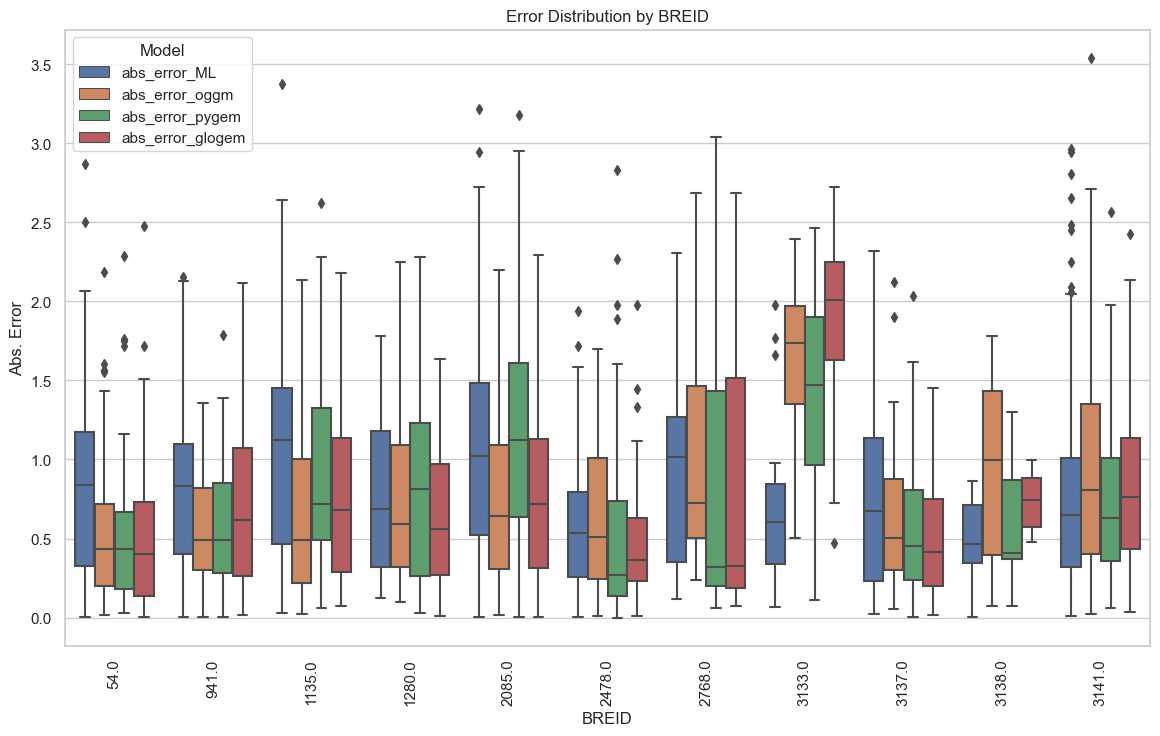

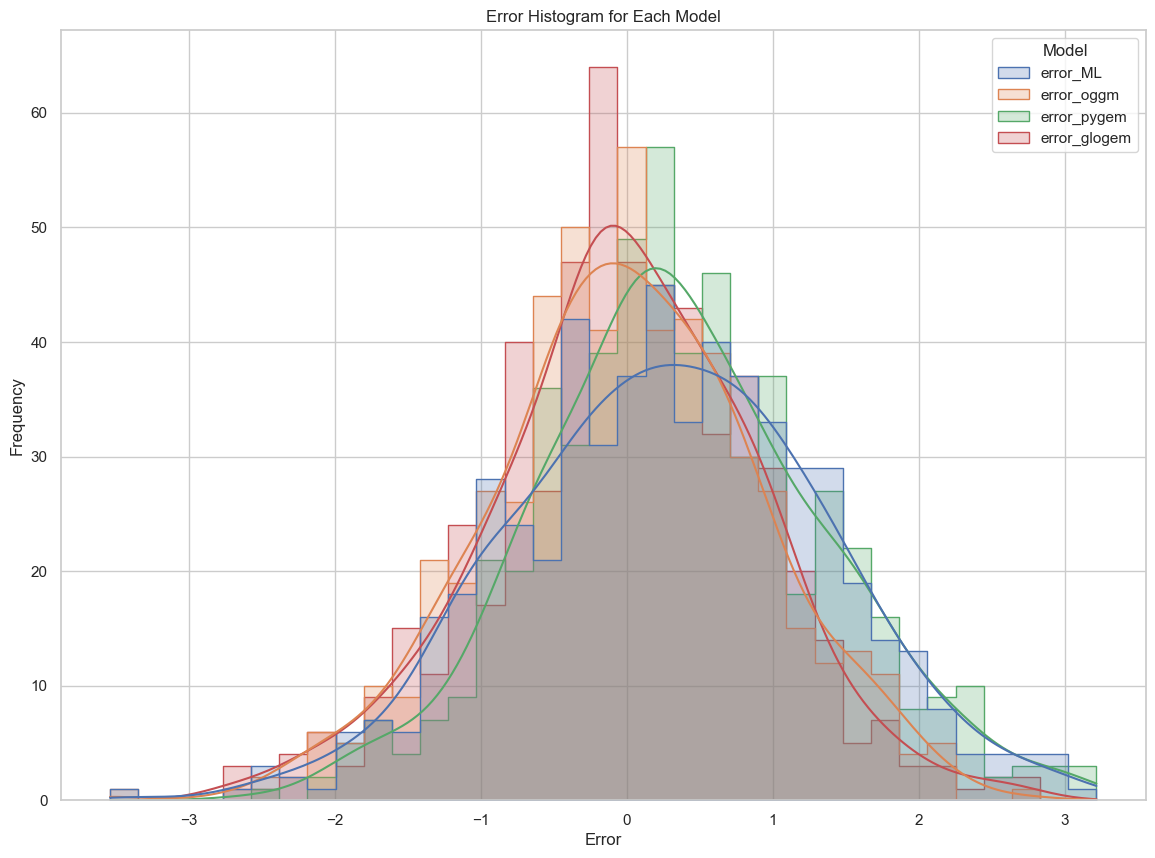

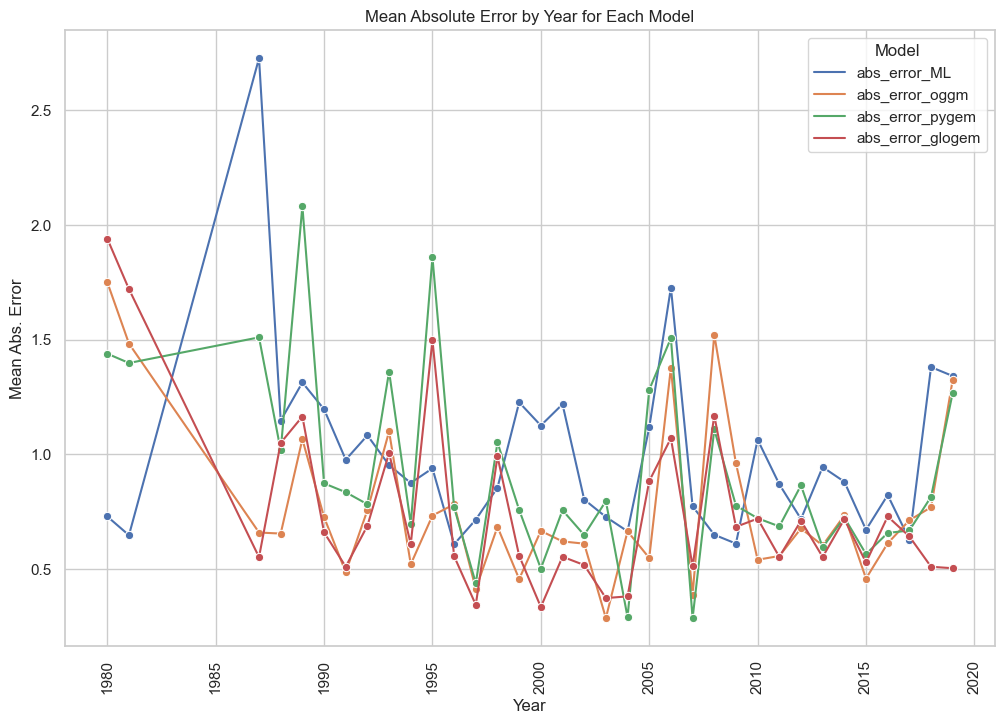

In [78]:
# Annual mass balance, only common points

create_box_plots(df_test_annual_nonan, 'BREID')

create_histograms(df_test_annual_nonan)

plot_mean_absolute_error_by_year(df_test_annual_nonan, 'year', ['abs_error_ML', 'abs_error_oggm', 'abs_error_pygem', 'abs_error_glogem'])

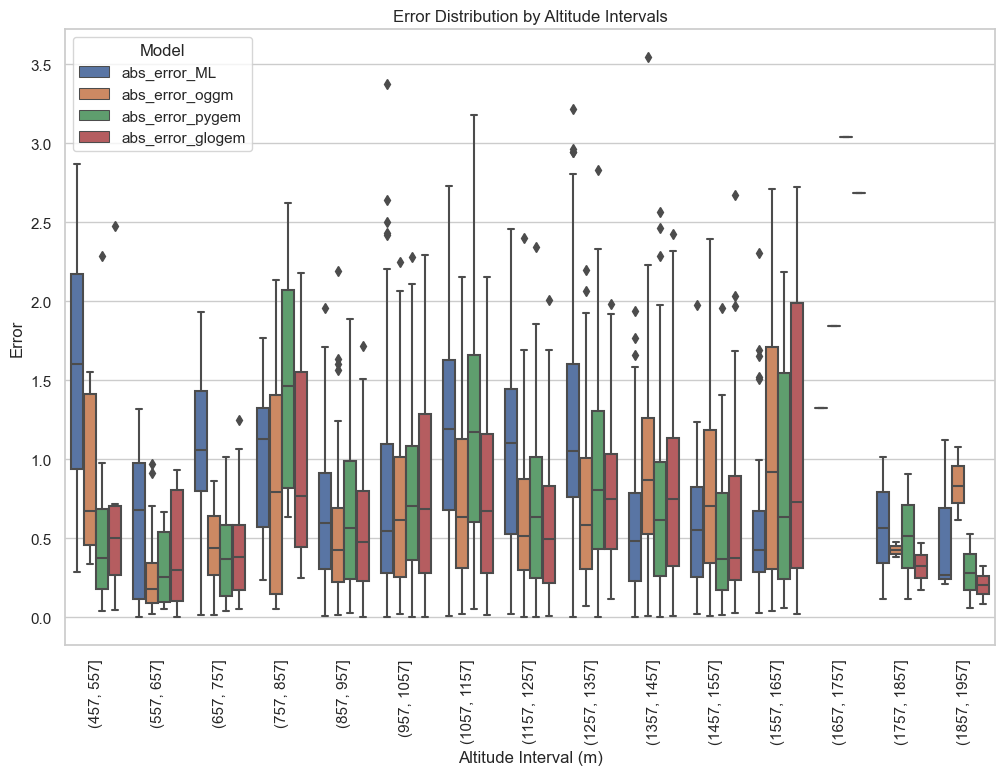

In [65]:
#plot_error_distribution_by_altitude_interval(df_test_annual_nonan, 'altitude', ['error_ML', 'error_oggm', 'error_pygem', 'error_glogem'], interval=100)

plot_error_distribution_by_altitude_interval(df_test_annual_nonan, 'altitude', ['abs_error_ML', 'abs_error_oggm', 'abs_error_pygem', 'abs_error_glogem'], interval=100)

### Summer mb, only common points

In [66]:
# Calculate errors for each model
df_test_summer_nonan['error_ML'] = df_test_summer_nonan['mb_ML'] - df_test_summer_nonan['balance']
df_test_summer_nonan['error_oggm'] = df_test_summer_nonan['mb_oggm'] - df_test_summer_nonan['balance']
df_test_summer_nonan['error_pygem'] = df_test_summer_nonan['mb_pygem'] - df_test_summer_nonan['balance']
df_test_summer_nonan['error_glogem'] = df_test_summer_nonan['mb_glogem'] - df_test_summer_nonan['balance']

df_test_summer_nonan['abs_error_ML'] = df_test_summer_nonan['error_ML'].abs()
df_test_summer_nonan['abs_error_oggm'] = df_test_summer_nonan['error_oggm'].abs()
df_test_summer_nonan['abs_error_pygem'] = df_test_summer_nonan['error_pygem'].abs()
df_test_summer_nonan['abs_error_glogem'] = df_test_summer_nonan['error_glogem'].abs()

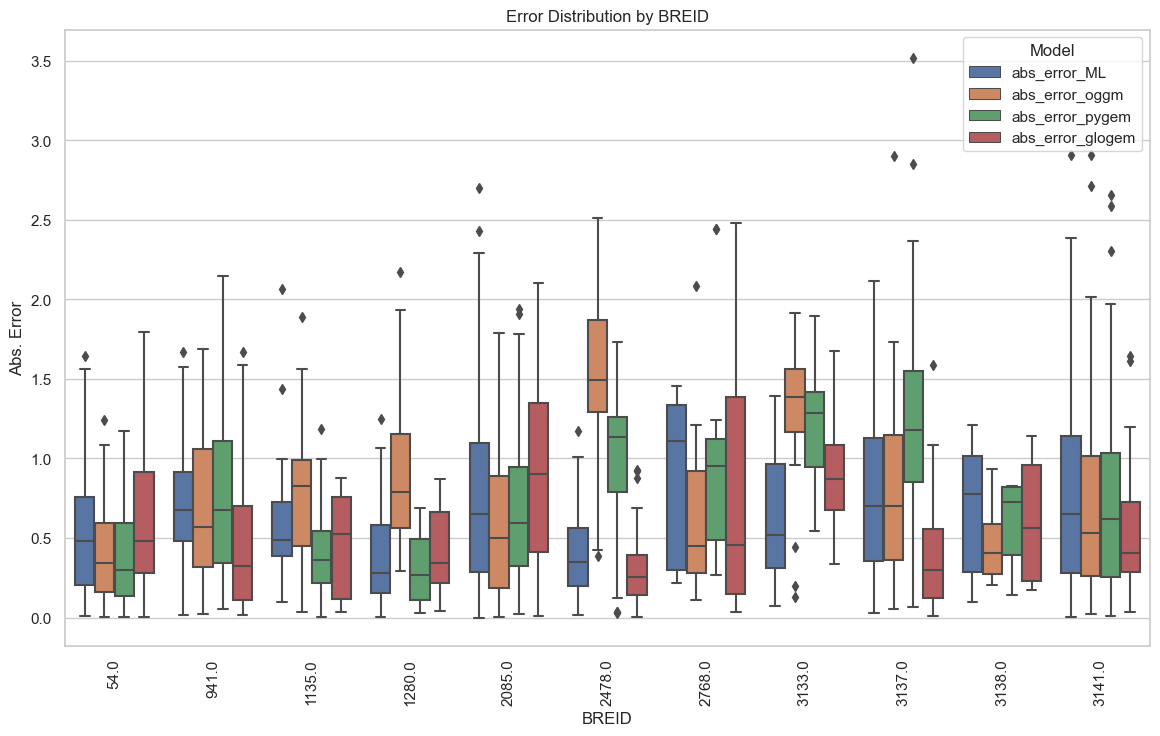

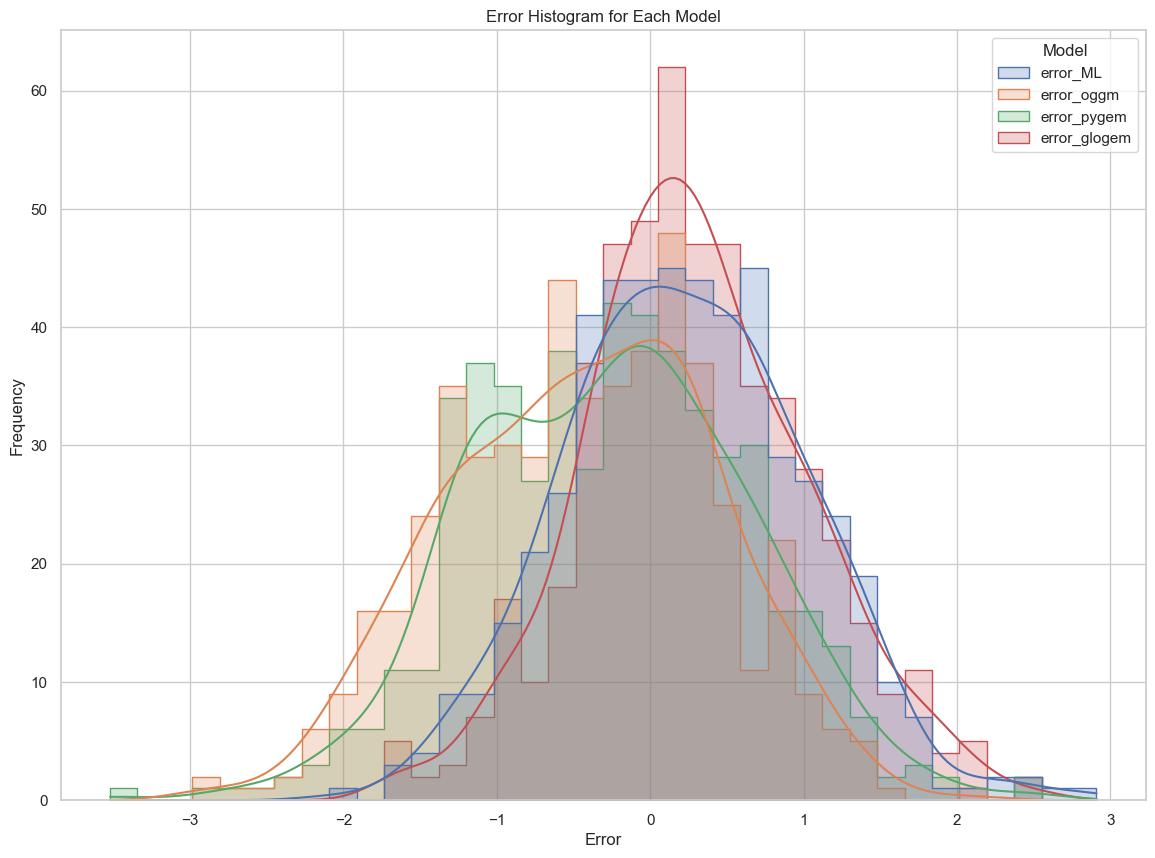

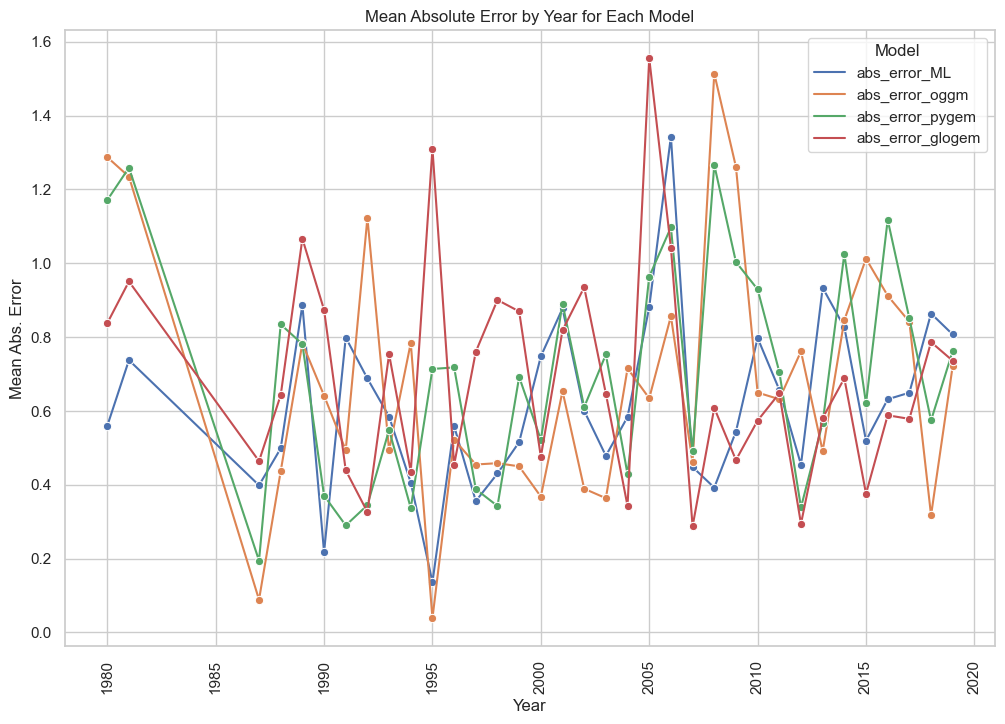

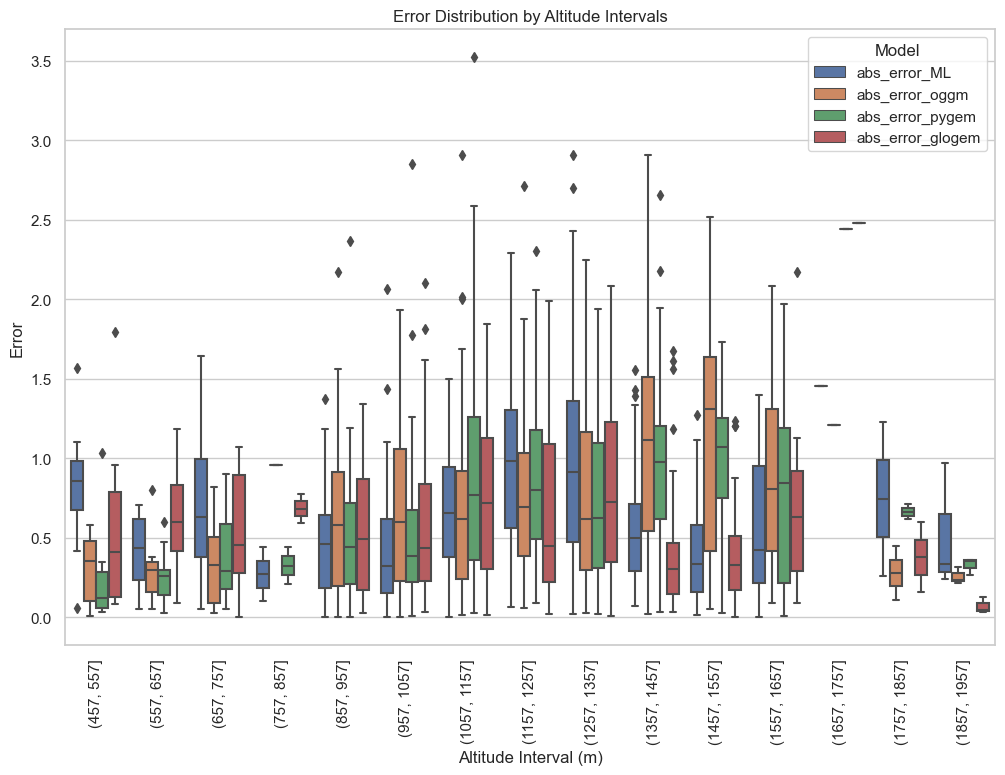

In [67]:
# Summer mass balance, only common points

create_box_plots(df_test_summer_nonan, 'BREID')

create_histograms(df_test_summer_nonan)

plot_mean_absolute_error_by_year(df_test_summer_nonan, 'year', ['abs_error_ML', 'abs_error_oggm', 'abs_error_pygem', 'abs_error_glogem'])

plot_error_distribution_by_altitude_interval(df_test_summer_nonan, 'altitude', ['abs_error_ML', 'abs_error_oggm', 'abs_error_pygem', 'abs_error_glogem'], interval=100)

### Winter mb, only common points

In [68]:
# Calculate errors for each model
df_test_winter_nonan['error_ML'] = df_test_winter_nonan['mb_ML'] - df_test_winter_nonan['balance']
df_test_winter_nonan['error_oggm'] = df_test_winter_nonan['mb_oggm'] - df_test_winter_nonan['balance']
df_test_winter_nonan['error_pygem'] = df_test_winter_nonan['mb_pygem'] - df_test_winter_nonan['balance']
df_test_winter_nonan['error_glogem'] = df_test_winter_nonan['mb_glogem'] - df_test_winter_nonan['balance']

df_test_winter_nonan['abs_error_ML'] = df_test_winter_nonan['error_ML'].abs()
df_test_winter_nonan['abs_error_oggm'] = df_test_winter_nonan['error_oggm'].abs()
df_test_winter_nonan['abs_error_pygem'] = df_test_winter_nonan['error_pygem'].abs()
df_test_winter_nonan['abs_error_glogem'] = df_test_winter_nonan['error_glogem'].abs()

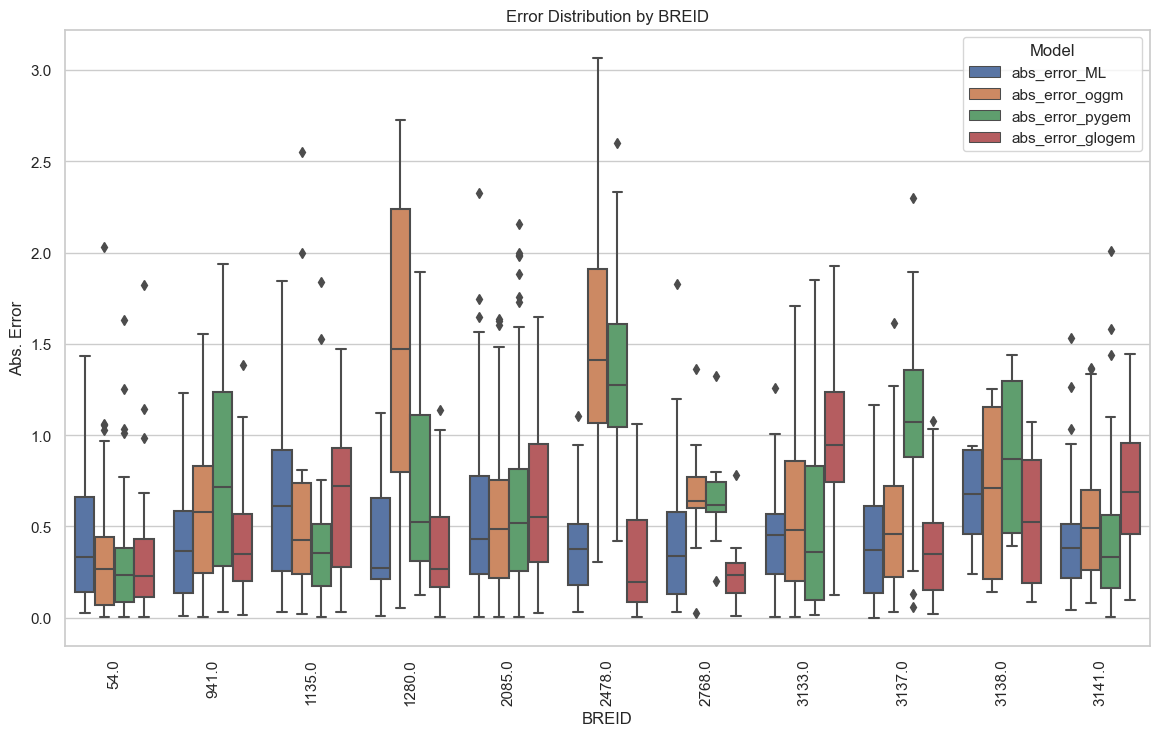

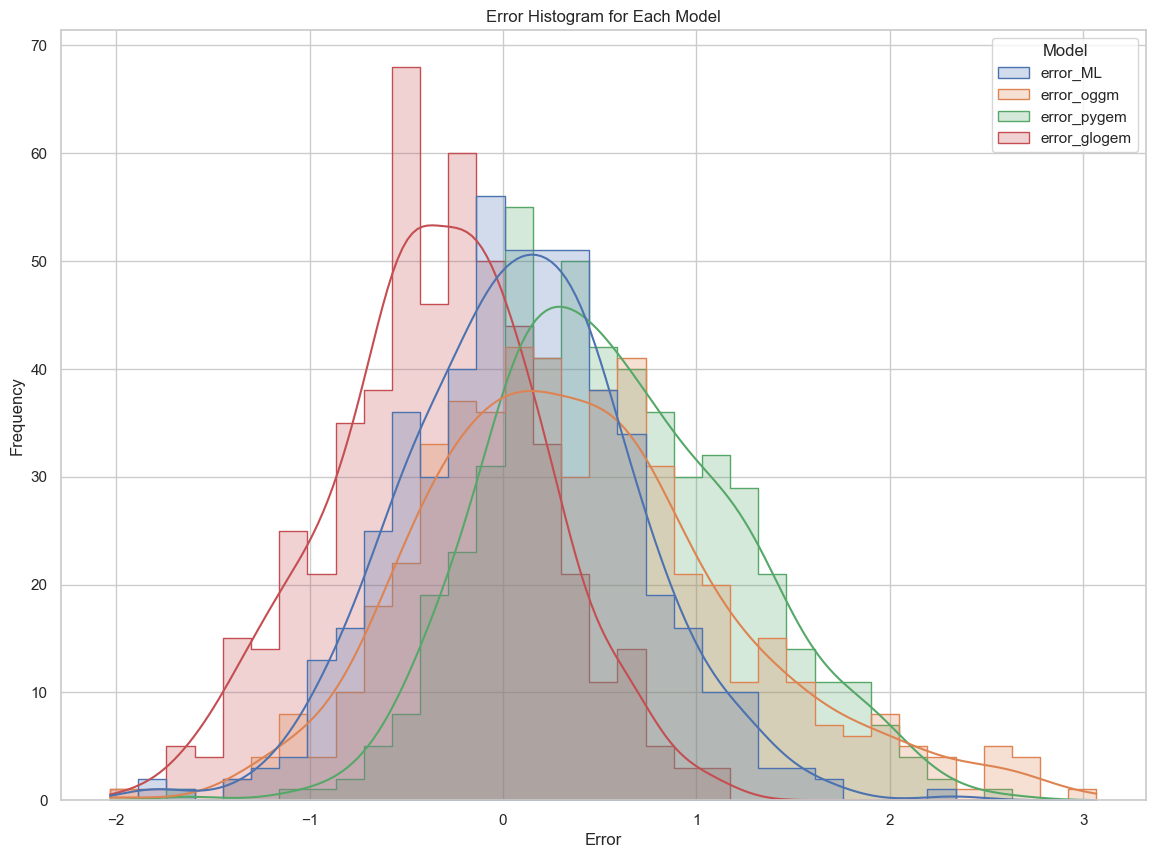

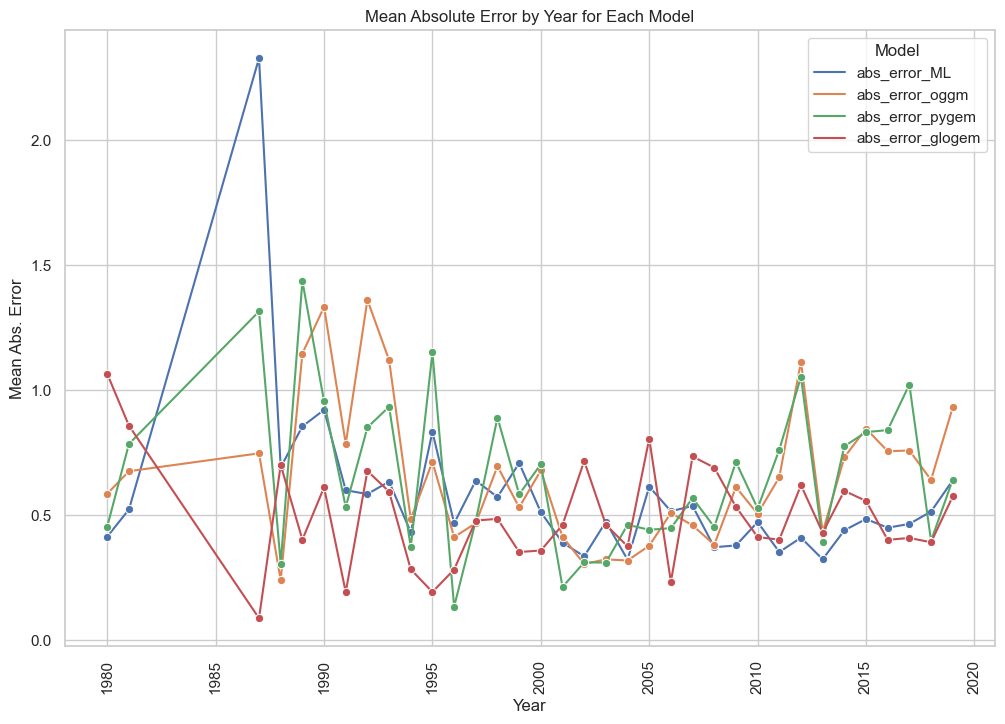

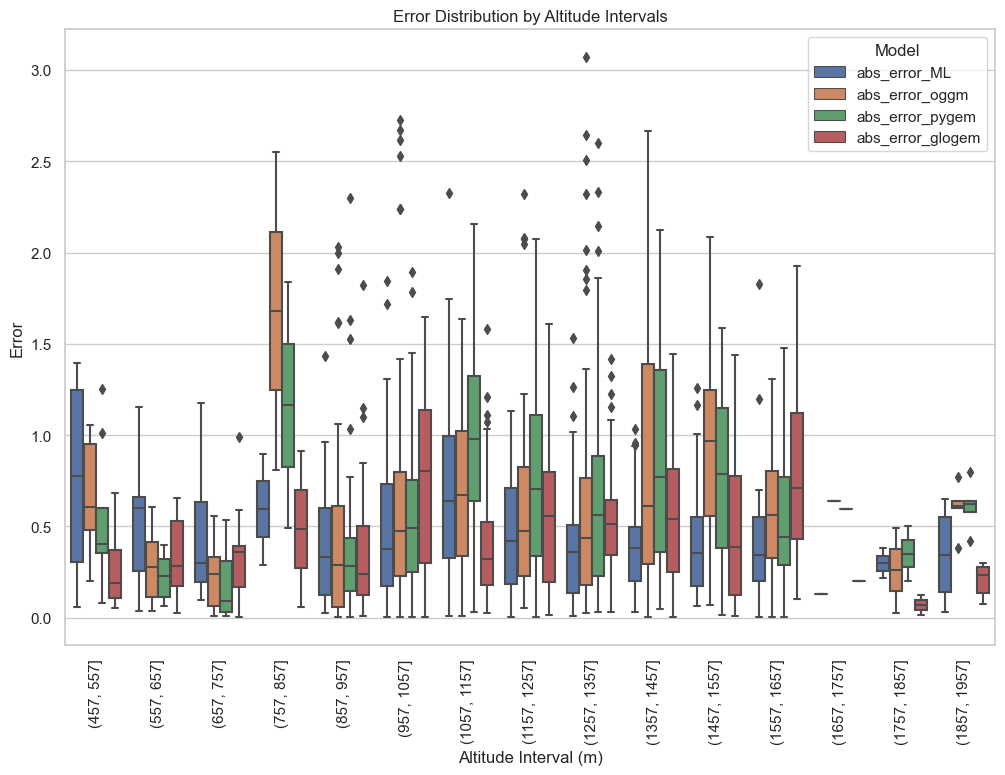

In [69]:
# Winter mass balance, only common points

create_box_plots(df_test_winter_nonan, 'BREID')

create_histograms(df_test_winter_nonan)

plot_mean_absolute_error_by_year(df_test_winter_nonan, 'year', ['abs_error_ML', 'abs_error_oggm', 'abs_error_pygem', 'abs_error_glogem'])

plot_error_distribution_by_altitude_interval(df_test_winter_nonan, 'altitude', ['abs_error_ML', 'abs_error_oggm', 'abs_error_pygem', 'abs_error_glogem'], interval=100)

### Annual mb, all points

In [242]:
# Calculate errors for each model
df_test_annual['error_ML'] = df_test_annual['mb_ML'] - df_test_annual['balance']
df_test_annual['error_oggm'] = df_test_annual['mb_oggm'] - df_test_annual['balance']
df_test_annual['error_pygem'] = df_test_annual['mb_pygem'] - df_test_annual['balance']
df_test_annual['error_glogem'] = df_test_annual['mb_glogem'] - df_test_annual['balance']

df_test_annual['abs_error_ML'] = df_test_annual['error_ML'].abs()
df_test_annual['abs_error_oggm'] = df_test_annual['error_oggm'].abs()
df_test_annual['abs_error_pygem'] = df_test_annual['error_pygem'].abs()
df_test_annual['abs_error_glogem'] = df_test_annual['error_glogem'].abs()

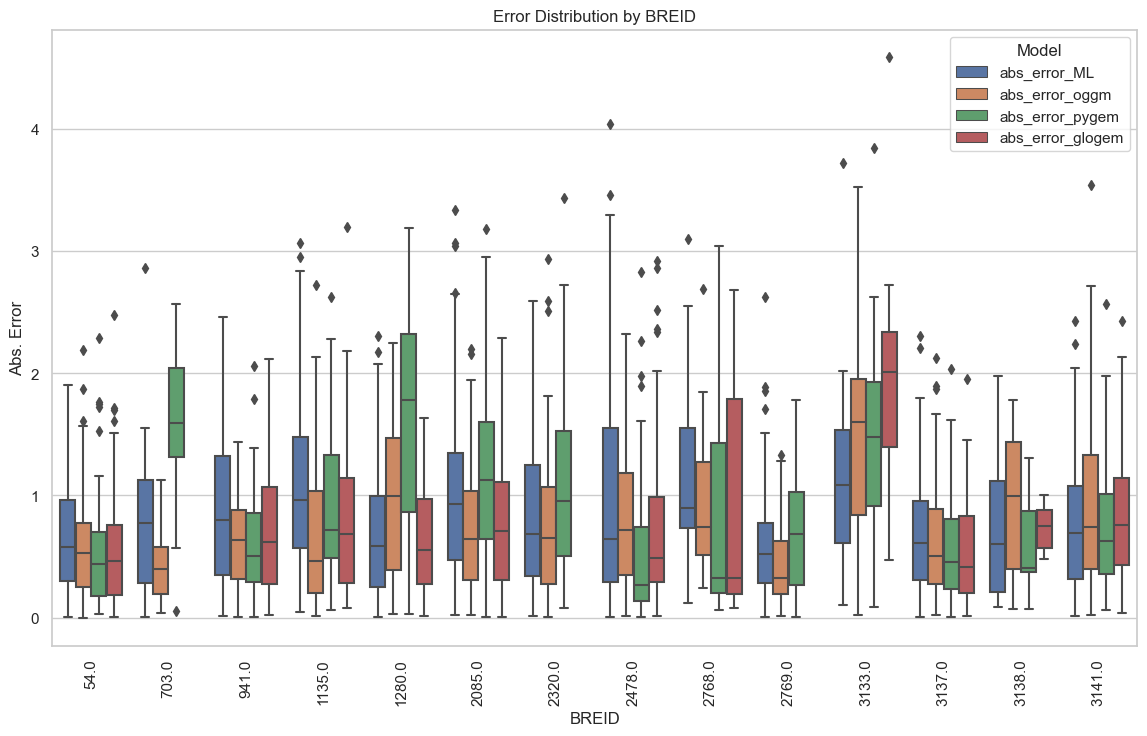

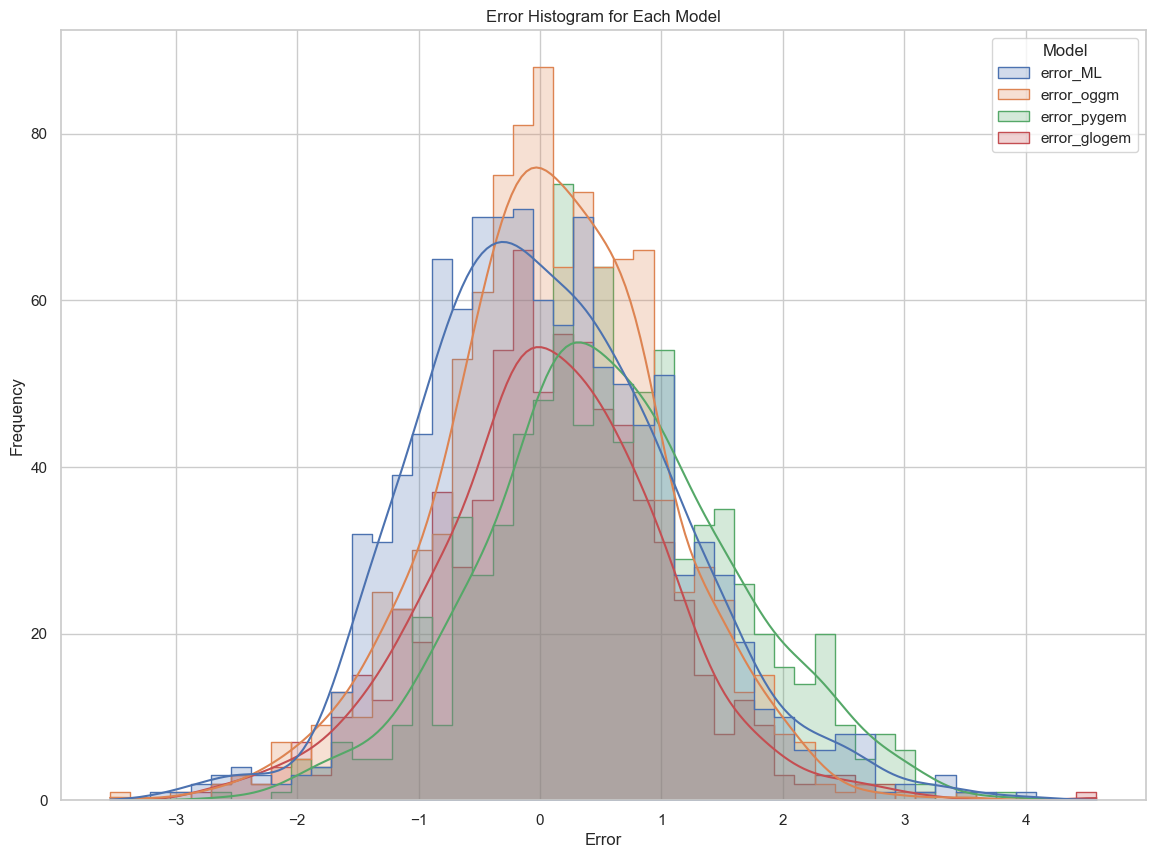

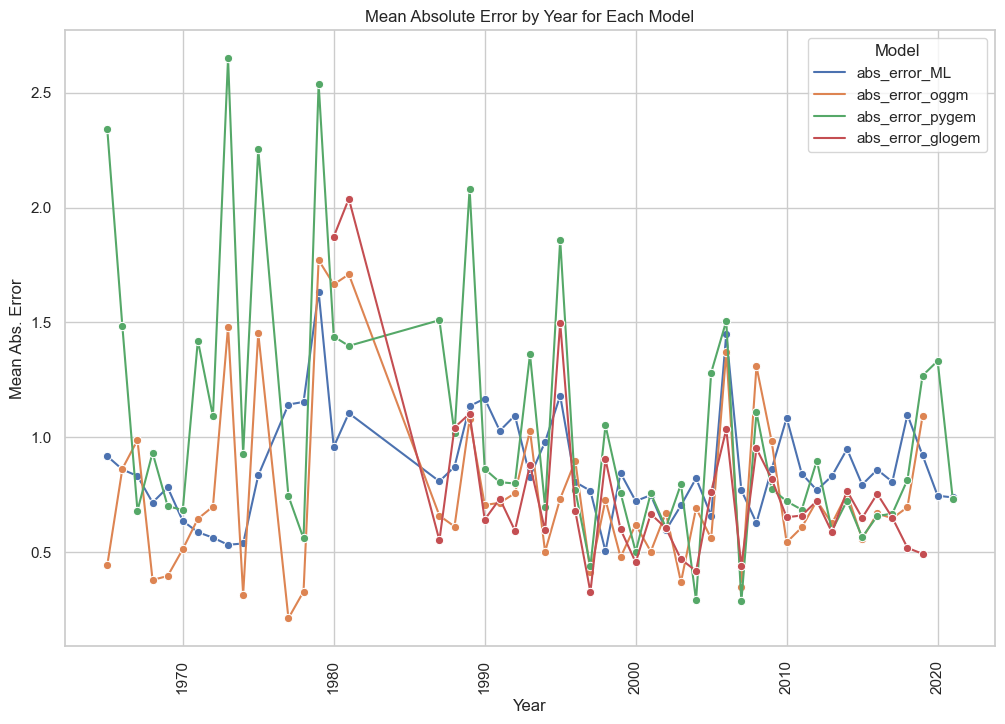

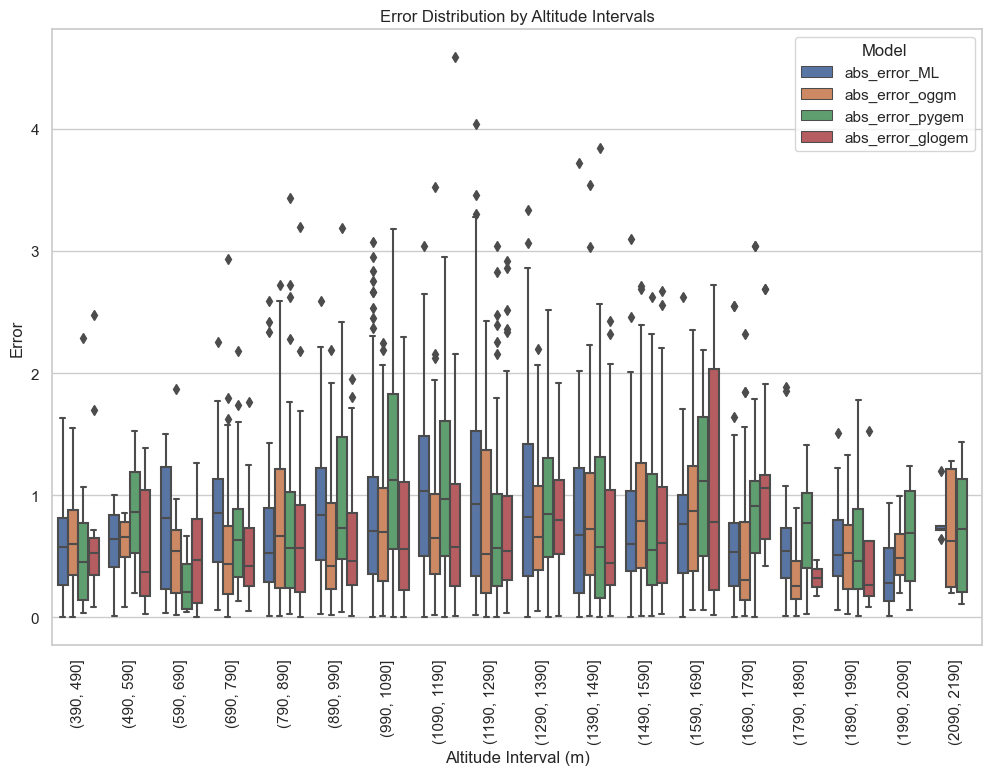

In [243]:
# Annual mass balance, all points

create_box_plots(df_test_annual, 'BREID')

create_histograms(df_test_annual)

plot_mean_absolute_error_by_year(df_test_annual, 'year', ['abs_error_ML', 'abs_error_oggm', 'abs_error_pygem', 'abs_error_glogem'])

plot_error_distribution_by_altitude_interval(df_test_annual, 'altitude', ['abs_error_ML', 'abs_error_oggm', 'abs_error_pygem', 'abs_error_glogem'], interval=100)

### Summer mb, all points

In [244]:
# Calculate errors for each model
df_test_summer['error_ML'] = df_test_summer['mb_ML'] - df_test_summer['balance']
df_test_summer['error_oggm'] = df_test_summer['mb_oggm'] - df_test_summer['balance']
df_test_summer['error_pygem'] = df_test_summer['mb_pygem'] - df_test_summer['balance']
df_test_summer['error_glogem'] = df_test_summer['mb_glogem'] - df_test_summer['balance']

df_test_summer['abs_error_ML'] = df_test_summer['error_ML'].abs()
df_test_summer['abs_error_oggm'] = df_test_summer['error_oggm'].abs()
df_test_summer['abs_error_pygem'] = df_test_summer['error_pygem'].abs()
df_test_summer['abs_error_glogem'] = df_test_summer['error_glogem'].abs()

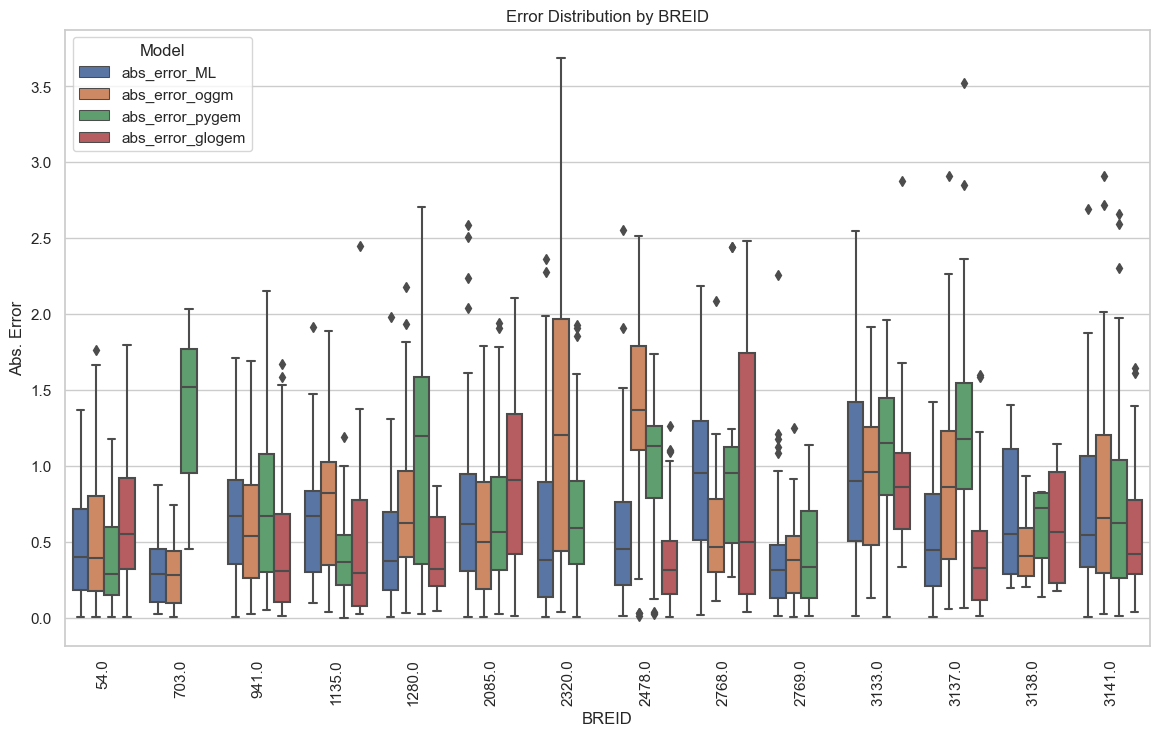

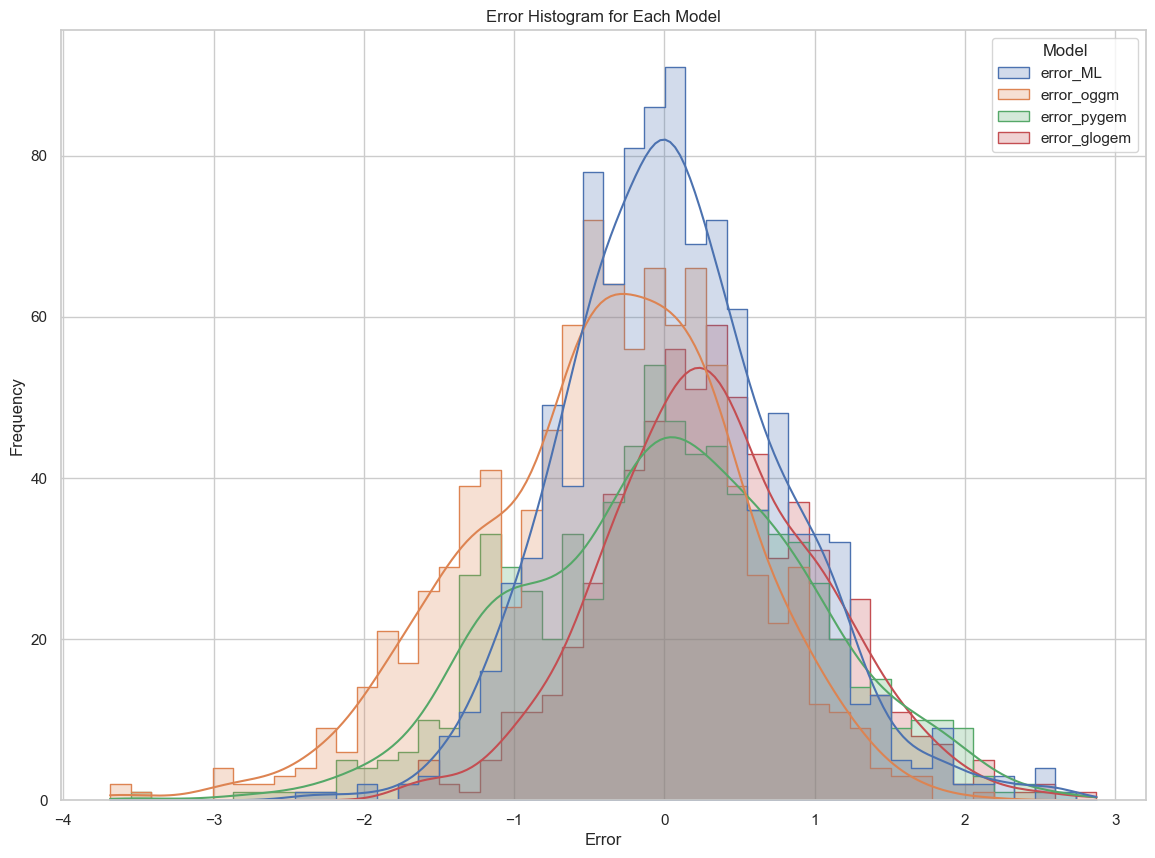

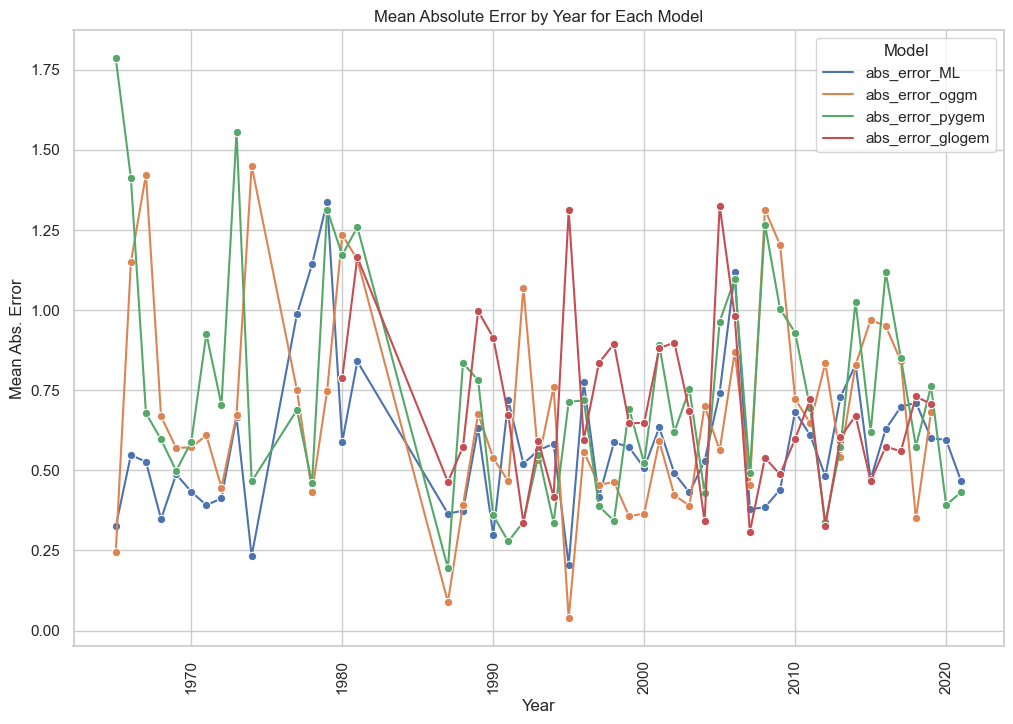

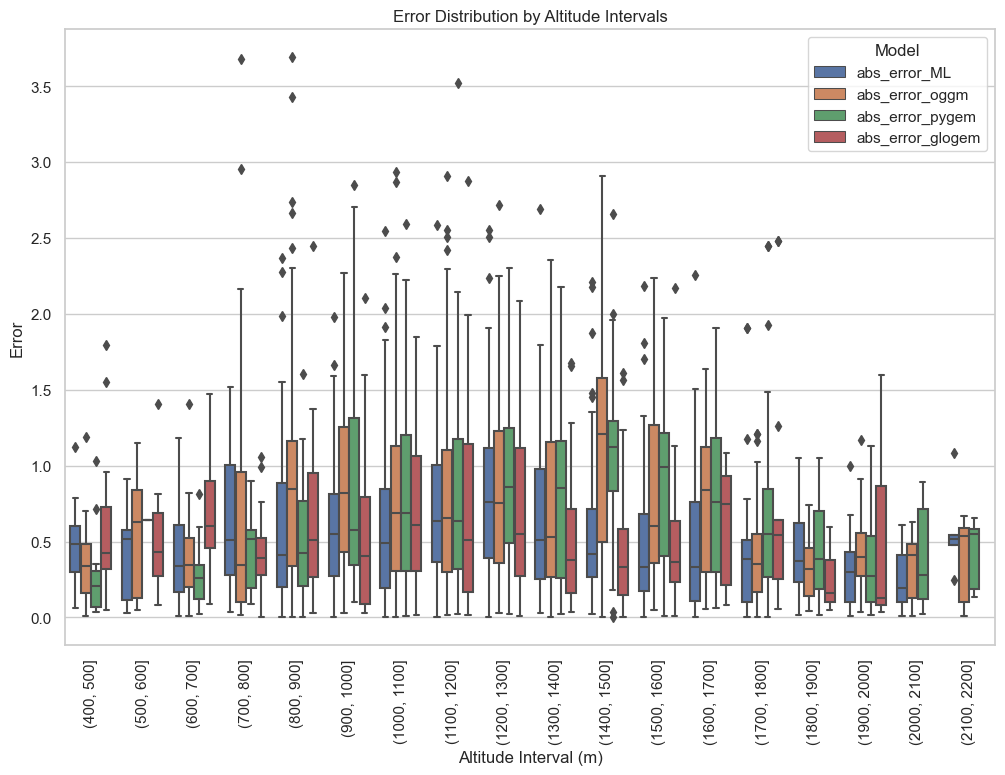

In [245]:
# Summer mass balance, all points

create_box_plots(df_test_summer, 'BREID')

create_histograms(df_test_summer)

plot_mean_absolute_error_by_year(df_test_summer, 'year', ['abs_error_ML', 'abs_error_oggm', 'abs_error_pygem', 'abs_error_glogem'])

plot_error_distribution_by_altitude_interval(df_test_summer, 'altitude', ['abs_error_ML', 'abs_error_oggm', 'abs_error_pygem', 'abs_error_glogem'], interval=100)

### Winter mb, all points

In [246]:
#Calculate errors for each model
df_test_winter['error_ML'] = df_test_winter['mb_ML'] - df_test_winter['balance']
df_test_winter['error_oggm'] = df_test_winter['mb_oggm'] - df_test_winter['balance']
df_test_winter['error_pygem'] = df_test_winter['mb_pygem'] - df_test_winter['balance']
df_test_winter['error_glogem'] = df_test_winter['mb_glogem'] - df_test_winter['balance']

df_test_winter['abs_error_ML'] = df_test_winter['error_ML'].abs()
df_test_winter['abs_error_oggm'] = df_test_winter['error_oggm'].abs()
df_test_winter['abs_error_pygem'] = df_test_winter['error_pygem'].abs()
df_test_winter['abs_error_glogem'] = df_test_winter['error_glogem'].abs()

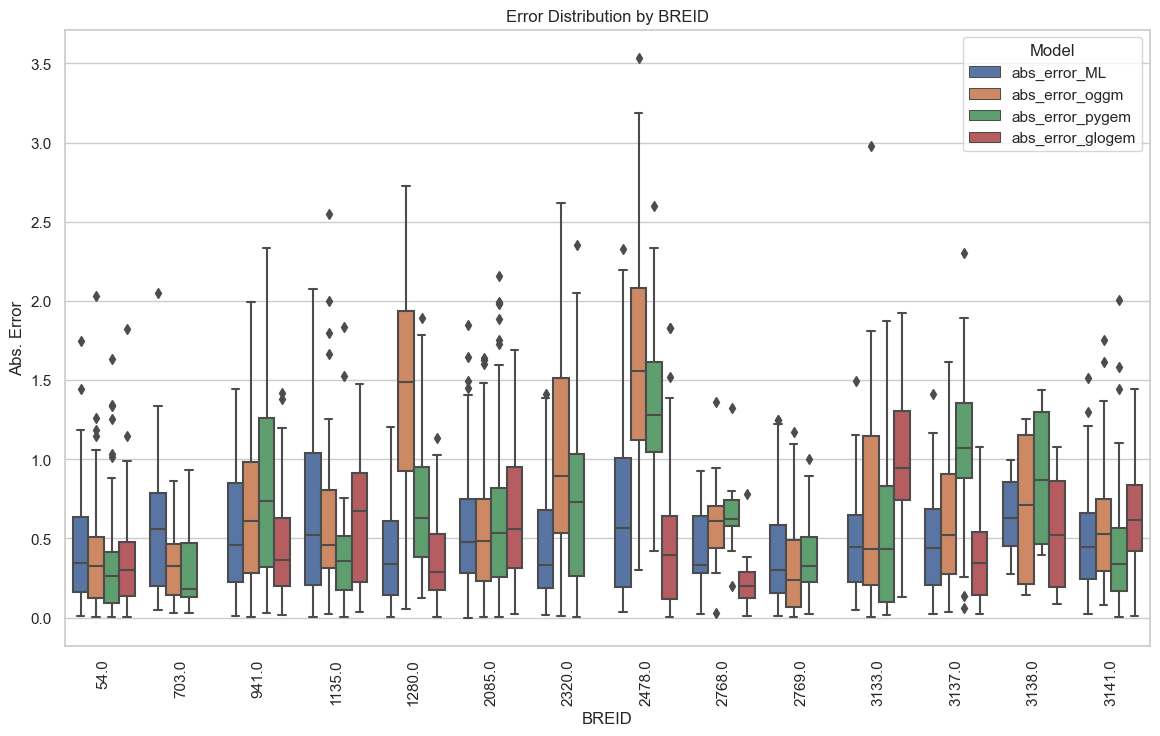

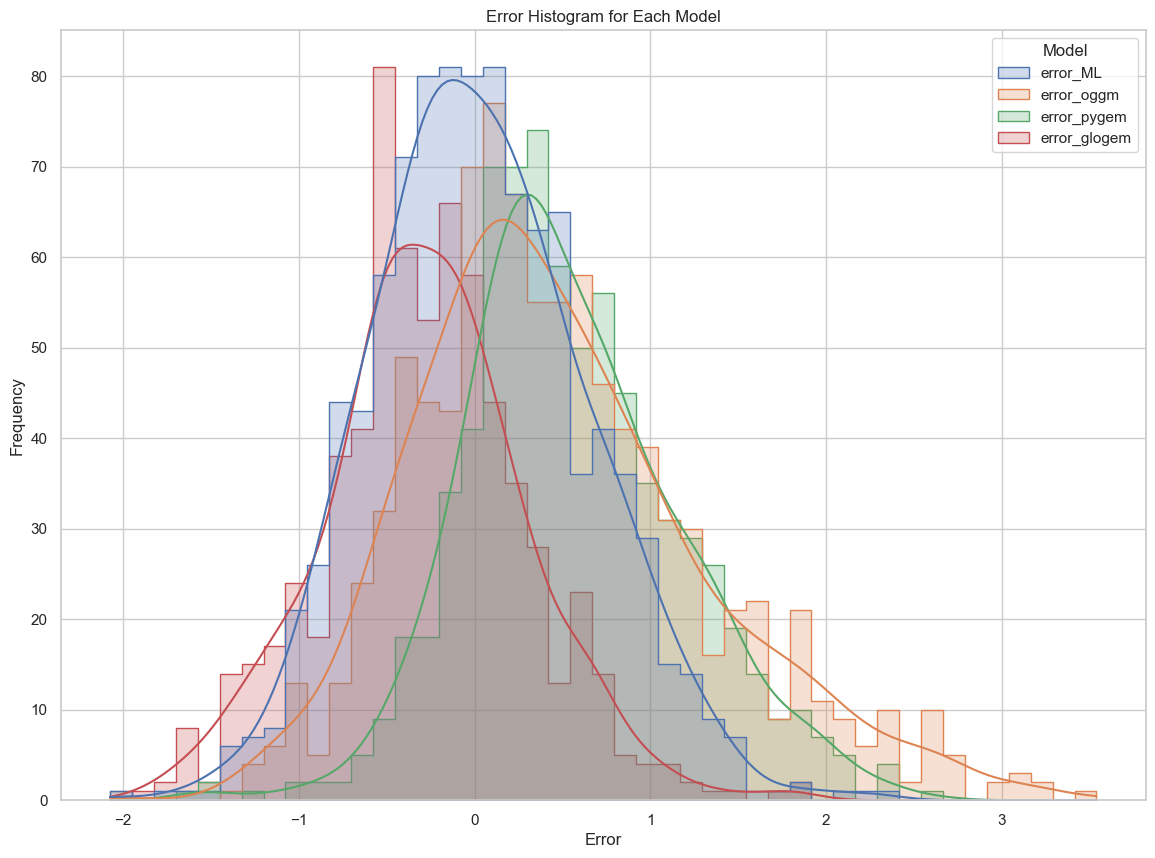

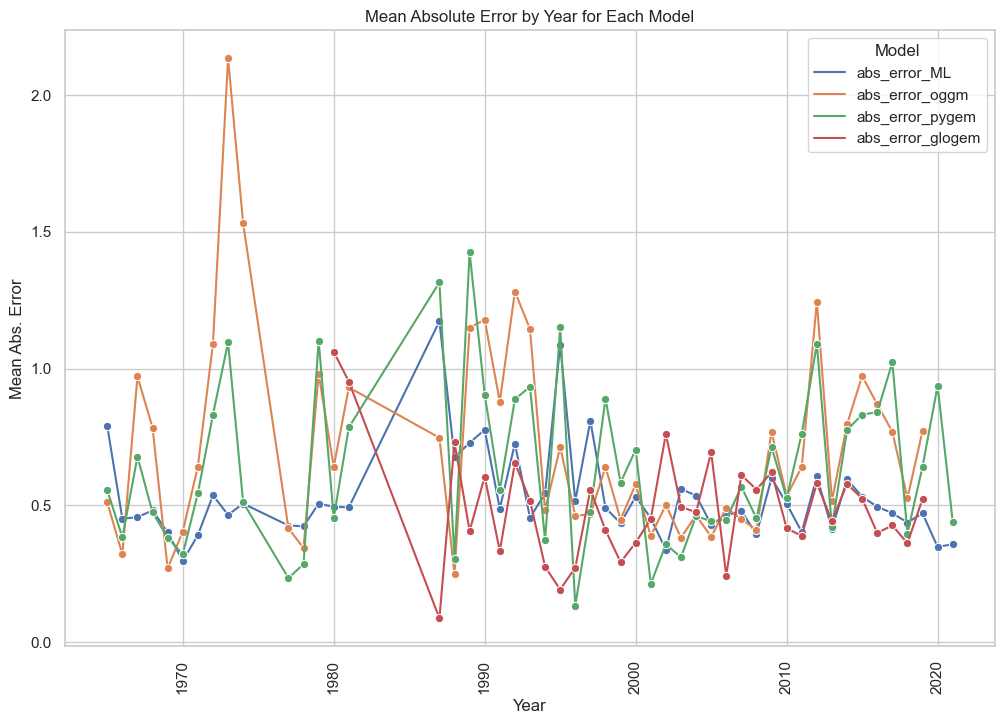

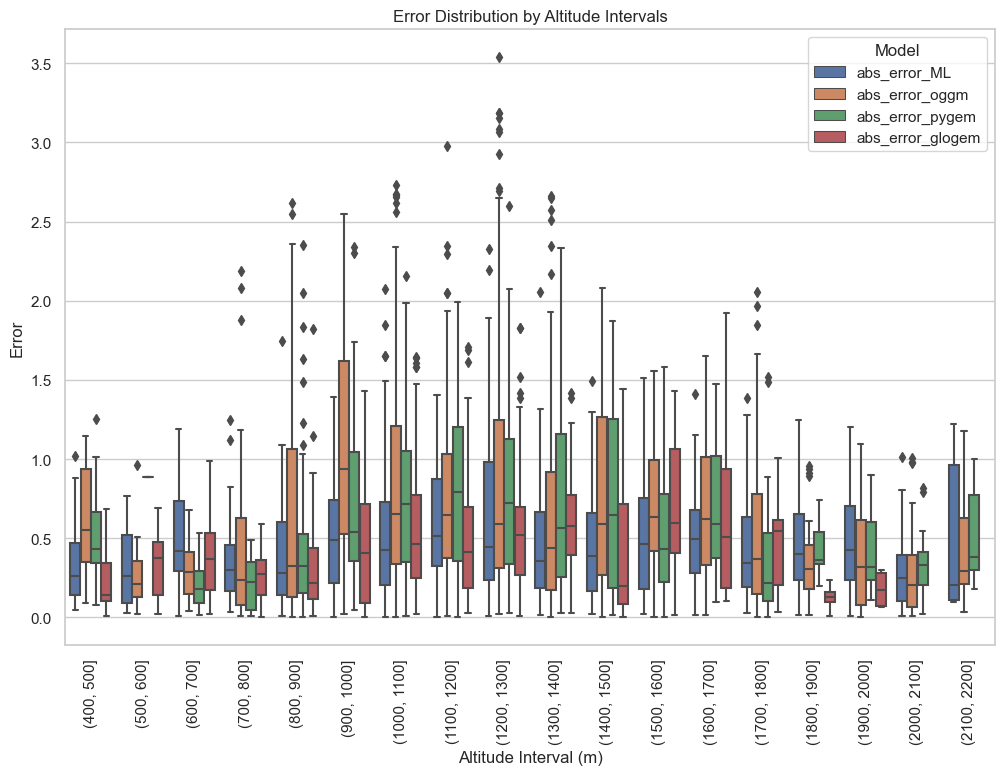

In [247]:
# Winter mass balance, all points

create_box_plots(df_test_winter, 'BREID')

create_histograms(df_test_winter)

plot_mean_absolute_error_by_year(df_test_winter, 'year', ['abs_error_ML', 'abs_error_oggm', 'abs_error_pygem', 'abs_error_glogem'])

plot_error_distribution_by_altitude_interval(df_test_winter, 'altitude', ['abs_error_ML', 'abs_error_oggm', 'abs_error_pygem', 'abs_error_glogem'], interval=100)